In [1]:
import pandas as pd
import re
import timeit
import seaborn as sns
import lightgbm as lgb
import numpy as np
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
import sklearn.metrics as sm
from sklearn.ensemble import IsolationForest
import plotly.express as px
import numpy as np
import warnings
import datetime
import xgboost as xgb
import math
import joblib
import matplotlib.pyplot as plt
from sklearn.experimental import enable_halving_search_cv # noqa
from sklearn.model_selection import HalvingGridSearchCV
import tsaug
from tsaug.visualization import plot
import statsmodels.api as sm
from patsy import dmatrices
import smogn
from catboost import CatBoostRegressor
from pycm import *



warnings.filterwarnings("ignore")

#Imports TFG Original
from prettytable import PrettyTable
from os import listdir
from os.path import isfile, join
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import accuracy_score , mean_squared_error
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from yellowbrick.model_selection import FeatureImportances
from sklearn.linear_model import LinearRegression, HuberRegressor, RANSACRegressor



## Funció Alineament de Dades

In [2]:
def alignSeries(serie, lag):
    minutesRow = 30
    posToMove = int(lag / minutesRow)  
    outputSerie = serie['data'].to_numpy()
    size = len(outputSerie)
    outputSerie = np.pad(outputSerie, (posToMove,0), 'constant', constant_values=(0))
    outputSerie = outputSerie[:size]
    return outputSerie

## Carregar Dades

In [3]:
def prepareDFMod(df, col):
    output = df[[col]]
    output.rename(columns={col:'data'}, inplace=True)
    return output
    

In [4]:
# Carregar dades pluja
def loadDataPrecipitacions():
    precipitacions = pd.read_excel("finalsDF/DF_SMC.xlsx", index_col=0)
    return precipitacions

In [5]:
# Carregar dades Alt Ter
def loadDataTer(nom, Ter):
    
    altTer = prepareDFMod(Ter, nom)
    
    return altTer

In [6]:
#Carregar dades precipitacions Alt Ter:
def loadDataPrecipitacions(nom, precipitacions):
    
    #Carregar dades
    precipitacions = prepareDFMod(precipitacions, nom)
    
    #Moving Average
    precipitacions['data'] = precipitacions['data'].rolling(window=5).mean()
    precipitacions['data'] = precipitacions['data'].rolling(window=5).mean()
    
    return precipitacions

In [7]:
altTer = pd.read_excel("Dataframes/df_imputedAltTerKNN.xlsx", index_col=0)
baixTer = pd.read_excel("Dataframes/df_imputedBaixTerKNN.xlsx", index_col=0)
precipitacions = pd.read_csv("finalsDF/DF_SMC.csv", index_col=0)

# Alineament del DataFrame amb Referencia (Alt Ter)

In [8]:
idx = pd.date_range("2009-01-01", periods=210386, freq="30T")

In [9]:
ts = pd.Series(range(len(idx)), index=range(len(idx)))

In [10]:
#Carregar Dades Comparatives

#Alinear Ripoll
ripoll = loadDataTer("L17147-72-00005", altTer)
ripoll = alignSeries(ripoll, 150)

#Alinear Sant Joan
santJoan = loadDataTer("L17167-72-00001", altTer)
santJoan = alignSeries(santJoan, 180)

#Alinear DG
DG = loadDataPrecipitacions("DG", precipitacions)
DG = alignSeries(DG, 270)

#Alinear CG 
CG = loadDataPrecipitacions("CG", precipitacions)
CG = alignSeries(CG, 300)

#Alinear CI
CI = loadDataPrecipitacions("CI", precipitacions)
CI = alignSeries(CI, 150)

#Alinear V4
V4 = loadDataPrecipitacions("V4", precipitacions)
V4 = alignSeries(V4, 180)

#Alinear CC
CC = loadDataPrecipitacions("CC", precipitacions)
CC = alignSeries(CC, 195)

#Alinear CY
CY = loadDataPrecipitacions("CY", precipitacions)
CY = alignSeries(CY, 240)

#Alinear VN
VN = loadDataPrecipitacions("VN", precipitacions)
VN = alignSeries(VN, 300)

#Alinear WS
WS = loadDataPrecipitacions("WS", precipitacions)
WS = alignSeries(WS, 300)

#Alinear V3

V3 = loadDataPrecipitacions("V3", precipitacions)
V3 = alignSeries(V3, 210)

#Z4_ZC

In [11]:
#Creem el DataFrame amb les dades alineades i el guardem 
dfAltX = pd.DataFrame(index=range(len(idx)))
dfAltX["L17147-72-00005"] = pd.Series(ripoll.tolist())
dfAltX["L17167-72-00001"] = pd.Series(santJoan.tolist())
dfAltX['DG'] = pd.Series(DG.tolist())
dfAltX['CG'] = pd.Series(CG.tolist())
dfAltX['CI'] = pd.Series(CI.tolist())
dfAltX['V4'] = pd.Series(V4.tolist())
dfAltX['CC'] = pd.Series(CC.tolist())
dfAltX['CY'] = pd.Series(CY.tolist())
dfAltX['VN'] = pd.Series(VN.tolist())
dfAltX['WS'] = pd.Series(WS.tolist())
dfAltX['V3'] = pd.Series(V3.tolist())



In [12]:
#Assignem les hores al index
dfAltX['datetime'] = pd.date_range("2009-01-01", periods=210386, freq="30T")
dfAltX.set_index('datetime', drop=True, inplace=True)

#Eliminem del top el maxim de posicions que hem alineat (en aquest cas 300)

minutesRow = 30
lag = 300
posToMove = int(lag / minutesRow)
dfAltX.drop(dfAltX.head(posToMove).index, inplace=True)
dfAltX.drop(dfAltX.tail(1).index, inplace=True)
dfAltX.fillna(0, inplace=True)


In [13]:
#Eliminem les mateixes columnes del 
masies = loadDataTer("L08116-72-00002", altTer)
masies.rename(columns={'data':'L08116-72-00002'}, inplace=True)
minutesRow = 30
lag = 300
posToMove = int(lag / minutesRow)
masies.drop(masies.head(posToMove).index, inplace=True)
dfAltY = masies
dfAltX.fillna(0, inplace=True)
dfAltY.fillna(0, inplace=True)

In [14]:
#Guardem el matrix de X y el array de y en un csv

dfAltX.to_csv('dfAltX.csv')
dfAltY.to_csv('dfAltY.csv')

# Alineament del DataFrame amb Referencia (Baix Ter)

In [15]:
idx = pd.date_range("2009-01-01", periods=210386, freq="30T")

In [16]:
ts = pd.Series(range(len(idx)), index=range(len(idx)))

In [17]:
#Carregar Dades Comparatives

#Alinear L17199-72-00001

L171997200001 = loadDataTer("L17199-72-00001", baixTer)
L171997200001 = alignSeries(L171997200001, 300)

#Alinear F026458

F026458 = loadDataTer("F026458", baixTer)
F026458 = alignSeries(F026458, 300)

#Alinear F001242
F001242 = loadDataTer("F001242", baixTer)
F001242 = alignSeries(F001242, 300)

#Alinear L170797200005
L170797200005 = loadDataTer("L17079-72-00005", baixTer)
L170797200005 = alignSeries(L170797200005, 270)

#Alinear L17079-72-00004

L170797200004 = loadDataTer("L17079-72-00004", baixTer)
L170797200004 = alignSeries(L170797200004, 270)

#Alinear L17038-72-00002

L170387200002 = loadDataPrecipitacions("L17038-72-00002", baixTer)
L170387200002 = alignSeries(L170387200002, 270)

#Alinear KE
KE = loadDataPrecipitacions("KE", precipitacions)
KE = alignSeries(KE, 300)

#Alinear UO
UO = loadDataPrecipitacions("UO", precipitacions)
UO = alignSeries(UO, 480)

#Alinear UN
UN = loadDataPrecipitacions("UN", precipitacions)
UN = alignSeries(UN, 405)

#Alinear WS
WS = loadDataPrecipitacions("WS", precipitacions)
WS = alignSeries(WS, 270)

#Alinear DJ

DJ = loadDataPrecipitacions("DJ", precipitacions)
DJ = alignSeries(DJ, 360)



In [18]:
#Creem el DataFrame amb les dades alineades i el guardem 
dfBaixX = pd.DataFrame(index=range(len(idx)))
dfBaixX["L17199-72-00001"] = pd.Series(L171997200001.tolist())
dfBaixX["F026458"] = pd.Series(F026458.tolist())
dfBaixX['F001242'] = pd.Series(F001242.tolist())
dfBaixX['L17079-72-00005'] = pd.Series(L170797200005.tolist())
dfBaixX['L17079-72-00004'] = pd.Series(L170797200004.tolist())
dfBaixX['L17038-72-00002'] = pd.Series(L170387200002.tolist())
dfBaixX['KE'] = pd.Series(KE.tolist())
dfBaixX['UO'] = pd.Series(UO.tolist())
dfBaixX['UN'] = pd.Series(UN.tolist())
dfBaixX['WS'] = pd.Series(WS.tolist())
dfBaixX['DJ'] = pd.Series(DJ.tolist())




In [19]:
#Assignem les hores al index
dfBaixX['datetime'] = pd.date_range("2009-01-01", periods=210386, freq="30T")
dfBaixX.set_index('datetime', drop=True, inplace=True)

#Eliminem del top el maxim de posicions que hem alineat (en aquest cas 300)

minutesRow = 30
lag = 300
posToMove = int(lag / minutesRow)
dfBaixX.drop(dfBaixX.head(posToMove).index, inplace=True)
dfBaixX.drop(dfBaixX.tail(1).index, inplace=True)
dfBaixX.fillna(0, inplace=True)

In [20]:
#Eliminem les mateixes columnes del 
colomers = loadDataTer("L17055-72-00002", baixTer)
colomers.rename(columns={'data':'L17055-72-00002'}, inplace=True)
minutesRow = 30
lag = 300
posToMove = int(lag / minutesRow)
colomers.drop(colomers.head(posToMove).index, inplace=True)
dfBaixY = colomers
dfBaixX.fillna(0, inplace=True)
dfBaixY.fillna(0, inplace=True)

In [21]:
#Guardem el matrix de X y el array de y en un csv

dfBaixX.to_csv('dfBaixX.csv')
dfBaixY.to_csv('dfBaixY.csv')

# Pre-processament de Dades (Data Augmentation, Splits, etc...)

## Train Only Events (seleccionar per Precipitacions)

In [14]:
#Carregar del csv
Df_AltX = pd.read_csv('dfAltX.csv')
Df_Alty = pd.read_csv('dfAltY.csv')
Df_BaixX = pd.read_csv('dfBaixX.csv')
Df_Baixy = pd.read_csv('dfBaixY.csv')

# Fiquem el datetime com a index
Df_Alty = Df_Alty.set_index('DATA')
Df_AltX = Df_AltX.set_index('datetime')
Df_Baixy = Df_Baixy.set_index('DATA')
Df_BaixX = Df_BaixX.set_index('datetime')



In [15]:
#Visualització de la distribució del plot per comprovar a partir de quin threshold de pluja tallar
#Alt Ter
Df_AltX['Pluja'] = Df_AltX[['DG','CG','CI','V4','CC','CY','VN','WS','V3']].mean(axis=1)
print(Df_AltX['Pluja'].shape)
Df_AltX = Df_AltX.loc[Df_AltX['Pluja'] < 0.1]
print(Df_AltX['Pluja'].shape)
Df_AltX.drop(columns=['Pluja'],inplace=True)
Df_Alty = Df_Alty.loc[np.intersect1d(Df_AltX.index, Df_Alty.index)]


#Baix Ter
Df_BaixX['Pluja'] = Df_BaixX[['KE','UO','UN','WS','DJ']].mean(axis=1)
print(Df_BaixX['Pluja'].shape)
Df_BaixX = Df_BaixX.loc[Df_BaixX['Pluja'] < 0.1]
print(Df_BaixX['Pluja'].shape)
Df_BaixX.drop(columns=['Pluja'],inplace=True)
Df_Baixy = Df_Baixy.loc[np.intersect1d(Df_BaixX.index, Df_Baixy.index)]




(210375,)
(190064,)
(210375,)
(194044,)


In [16]:
Df_AltX.to_csv('dfAltXStandard.csv')
Df_Alty.to_csv('dfAltYStandard.csv')
Df_BaixX.to_csv('dfBaixXStandard.csv')
Df_Baixy.to_csv('dfBaixYStandard.csv')

## Train Only Events (seleccionar per Cabal)

In [76]:
#Carregar del csv
Df_AltX = pd.read_csv('dfAltX.csv')
Df_Alty = pd.read_csv('dfAltY.csv')
Df_BaixX = pd.read_csv('dfBaixX.csv')
Df_Baixy = pd.read_csv('dfBaixY.csv')

# Fiquem el datetime com a index
Df_Alty = Df_Alty.set_index('DATA')
Df_AltX = Df_AltX.set_index('datetime')
Df_Baixy = Df_Baixy.set_index('DATA')
Df_BaixX = Df_BaixX.set_index('datetime')



In [77]:
#Informacion de la Media y Mitjana dels rius de referencia

meanAlt = Df_Alty['L08116-72-00002'].mean()
medianAlt = Df_Alty['L08116-72-00002'].median()
meanBaix = Df_Baixy['L17055-72-00002'].mean()
medianBaix = Df_Baixy['L17055-72-00002'].median()
print("Mean Referencia Alt Ter: ", meanAlt)
print("Mitjana Referencia Baix Ter: ", medianAlt)
print("Mean Referencia Alt Ter: ", meanBaix)
print("Mitjana Referencia Baix Ter: ", medianBaix)


Mean Referencia Alt Ter:  14.782792464811813
Mitjana Referencia Baix Ter:  9.976
Mean Referencia Alt Ter:  19.53263903718924
Mitjana Referencia Baix Ter:  13.34


In [78]:
#Visualització de la distribució del plot per comprovar a partir de quin threshold de pluja tallar
#Alt Ter

print(Df_Alty.shape)
Df_Alty = Df_Alty.loc[Df_Alty['L08116-72-00002'] > medianAlt]
print(Df_Alty.shape)
Df_AltX = Df_AltX.loc[np.intersect1d(Df_AltX.index, Df_Alty.index)]


#Baix Ter
print(Df_Baixy.shape)
Df_Baixy = Df_Baixy.loc[Df_Baixy['L17055-72-00002'] > medianBaix]
print(Df_Baixy.shape)
Df_BaixX = Df_BaixX.loc[np.intersect1d(Df_BaixX.index, Df_Baixy.index)]




(210375, 1)
(105182, 1)
(210375, 1)
(105182, 1)


In [79]:
Df_AltX.to_csv('dfAltXAnomaliesCabal.csv')
Df_Alty.to_csv('dfAltYAnomaliesCabal.csv')
Df_BaixX.to_csv('dfBaixXAnomaliesCabal.csv')
Df_Baixy.to_csv('dfBaixYAnomaliesCabal.csv')

## Train Only Events (with SMOGN)

In [32]:
#Carreguem les dades i les agrupem per utilitzar SMOGN
Df_AltX = pd.read_csv('dfAltXAnomalies.csv')
Df_Alty = pd.read_csv('dfAltYAnomalies.csv')
Df_BaixX = pd.read_csv('dfBaixXAnomalies.csv')
Df_Baixy = pd.read_csv('dfBaixYAnomalies.csv')

Df_AltX.drop('datetime',inplace=True, axis=1)
Df_Alty.drop('DATA', inplace=True, axis=1)
Df_BaixX.drop('datetime', inplace=True, axis=1)
Df_Baixy.drop('DATA', inplace=True, axis=1)

Df_AltX['L08116-72-00002'] = Df_Alty['L08116-72-00002']
Df_BaixX['L17055-72-00002'] = Df_Baixy['L17055-72-00002']


In [33]:
#SMOGN Alt Ter
print('Dimensions pre-SMOGN: ', Df_AltX.shape)
Df_AltX_Smogn = smogn.smoter(
    
    ## main arguments
    data = Df_AltX,           ## pandas dataframe
    y = 'L08116-72-00002',    ## string ('header name')
    k = 9,                    ## positive integer (k < n)
    samp_method = 'extreme',  ## string ('balance' or 'extreme')
    rel_thres = 0.10
)
print('Dimensions post-SMOGN: ', Df_AltX_Smogn.shape)



Dimensions pre-SMOGN:  (6205, 12)


r_index: 100%|#####################################################################| 563/563 [00:00<00:00, 1180.74it/s]


Dimensions post-SMOGN:  (6918, 12)


In [24]:
#SMOGN Baix Ter
print('Dimensions pre-SMOGN: ', Df_BaixX.shape)
Df_BaixX_Smogn = smogn.smoter(
    
    ## main arguments
    data = Df_BaixX,           ## pandas dataframe
    y = 'L17055-72-00002',    ## string ('header name')
    k = 5,                    ## positive integer (k < n)
    samp_method = 'extreme',  ## string ('balance' or 'extreme')
)
print('Dimensions post-SMOGN: ', Df_BaixX_Smogn.shape)

Dimensions pre-SMOGN:  (5667, 12)


r_index: 100%|#####################################################################| 514/514 [00:00<00:00, 1185.58it/s]


Dimensions post-SMOGN:  (7441, 12)


In [35]:
Df_AltX_Smogn = Df_AltX_Smogn.reset_index(drop=True)
Df_BaixX_Smogn = Df_BaixX_Smogn.reset_index(drop=True)

<AxesSubplot:xlabel='L08116-72-00002', ylabel='Density'>

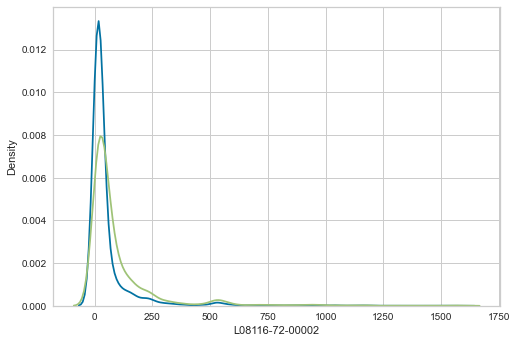

In [36]:
#Canvi distribucio
sns.kdeplot(Df_AltX['L08116-72-00002'], label='Original')
sns.kdeplot(Df_AltX_Smogn['L08116-72-00002'], label='Modificat')

In [ ]:
#Canvi distribucio
sns.kdeplot(Df_BaixX['L17055-72-00002'], label='Original')
sns.kdeplot(Df_BaixX_Smogn['L17055-72-00002'], label='Modificat')

In [ ]:
Df_Alty['L08116-72-00002'] = Df_AltX_Smogn['L08116-72-00002']
Df_AltX = Df_AltX_Smogn.drop(columns=['L08116-72-00002'])
Df_Baixy['L17055-72-00002'] = Df_BaixX_Smogn['L17055-72-00002']
Df_BaixX = Df_BaixX_Smogn.drop(columns=['L17055-72-00002'])

In [ ]:
Df_Alty = Df_AltX_Smogn['L08116-72-00002'].to_frame()
Df_Alty
Df_Baixy = Df_BaixX_Smogn['L17055-72-00002']
Df_Baixy

In [ ]:
Df_AltX.to_csv('dfAltXSMOGNCabal.csv',index=False)
Df_Alty.to_csv('dfAltYSMOGNCabal.csv',index=False)
Df_BaixX.to_csv('dfBaixXSMOGNCabal.csv',index=False)
Df_Baixy.to_csv('dfBaixYSMOGNCabal.csv',index=False)

## Data Augmentation (Adding Noise)

In [2]:
#Carregar del csv
Df_AltX = pd.read_csv('dfAltX.csv')
Df_Alty = pd.read_csv('dfAltY.csv')
Df_BaixX = pd.read_csv('dfBaixX.csv')
Df_Baixy = pd.read_csv('dfBaixY.csv')

In [3]:
Df_AltX.set_index('datetime', drop=True, inplace=True)
Df_BaixX.set_index('datetime', drop=True, inplace=True)

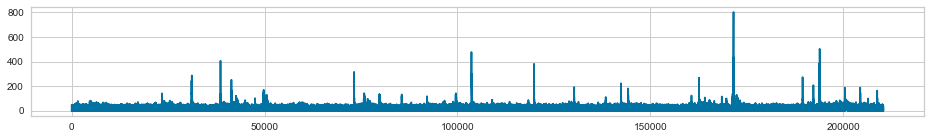

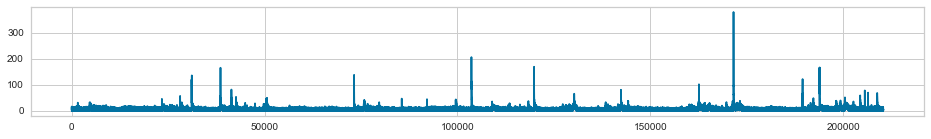

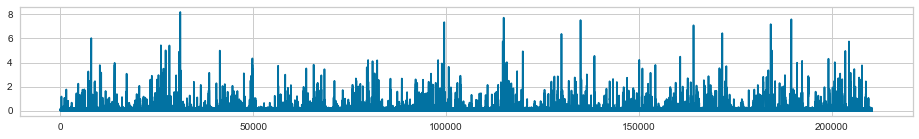

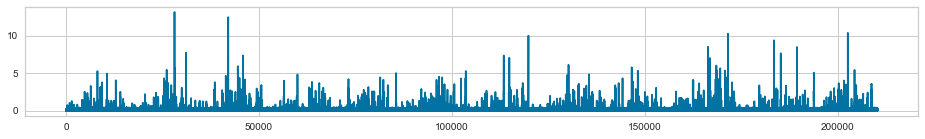

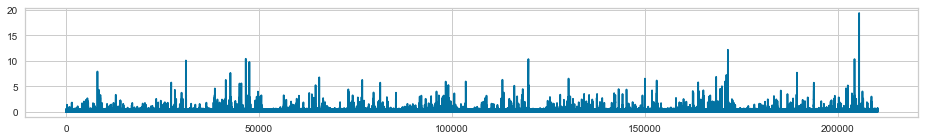

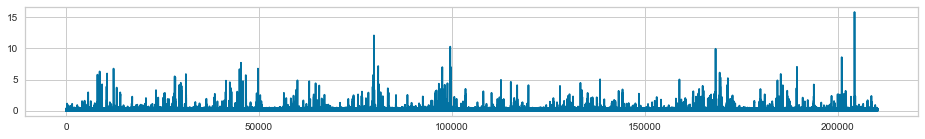

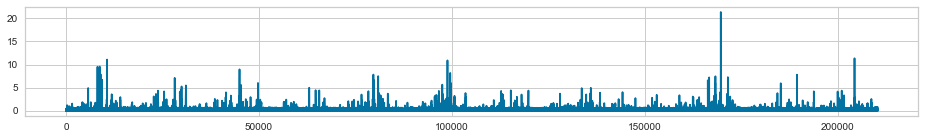

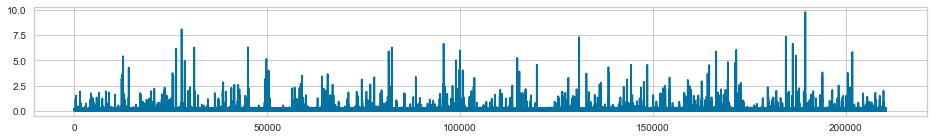

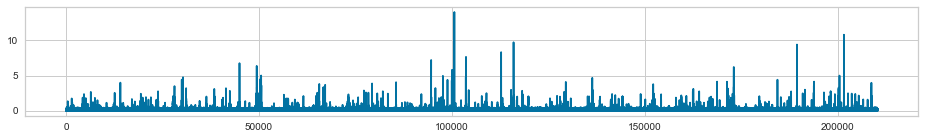

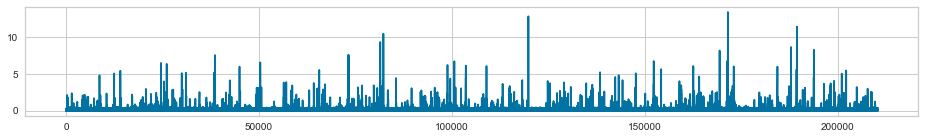

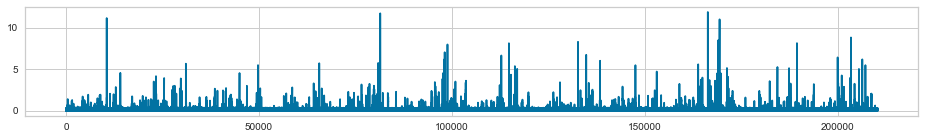

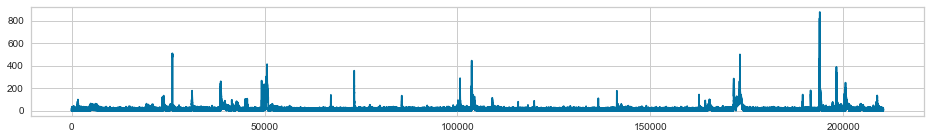

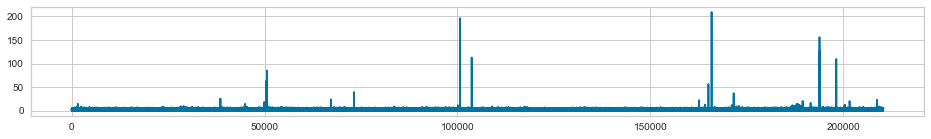

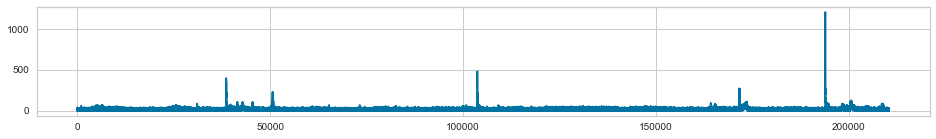

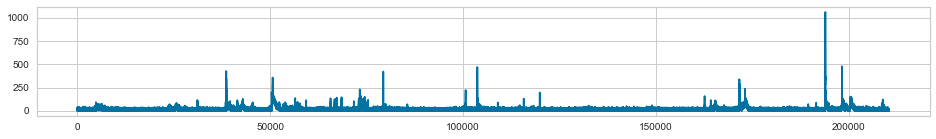

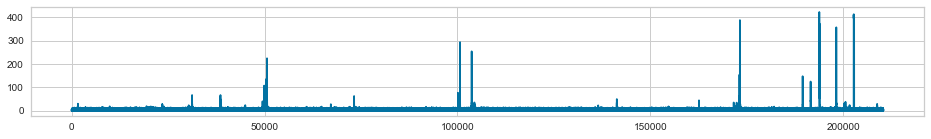

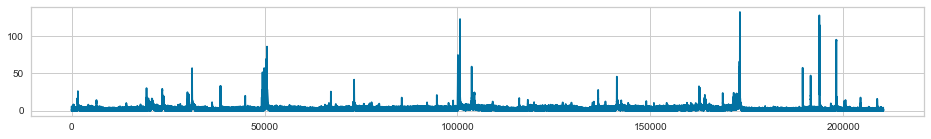

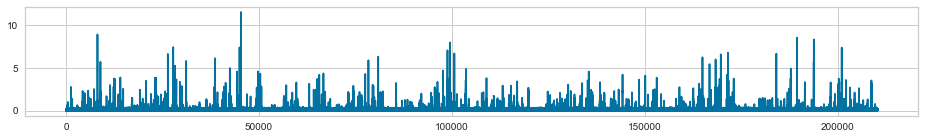

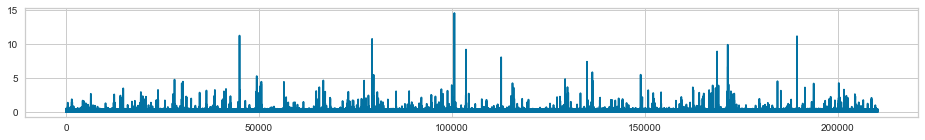

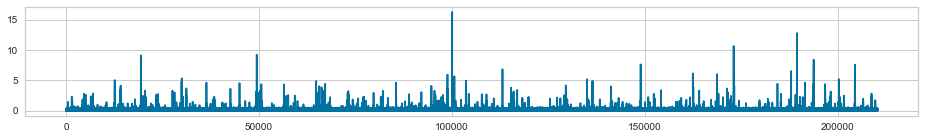

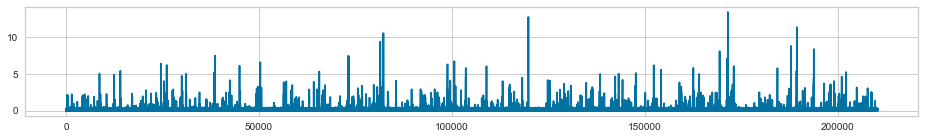

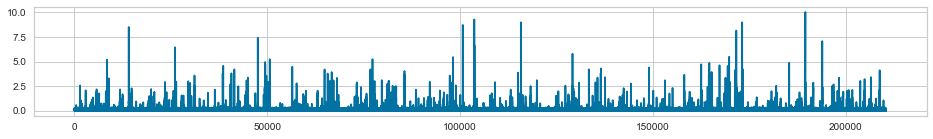

In [8]:
def addNoiseTimeSeries(df, scale=0.01):
    for column in df:
        array = df[column].to_numpy()
        aug = abs(tsaug.AddNoise(scale=scale).augment(array))
        df[column] = aug
        plot(aug)

addNoiseTimeSeries(Df_AltX)
addNoiseTimeSeries(Df_BaixX)


In [11]:
Df_AltX.to_csv('dfAltXNoise.csv')
Df_BaixX.to_csv('dfBaixXNoise.csv')

# Seleccionar DataSet

In [19]:
def datasetAlignNormal():
    Df_AltX = pd.read_csv('dfAltX.csv')
    Df_Alty = pd.read_csv('dfAltY.csv')
    Df_BaixX = pd.read_csv('dfBaixX.csv')
    Df_Baixy = pd.read_csv('dfBaixY.csv')
    Df_AltX.set_index('datetime', drop=True, inplace=True)
    Df_Alty.set_index('DATA', drop=True, inplace=True)
    Df_BaixX.set_index('datetime', drop=True, inplace=True)
    Df_Baixy.set_index('DATA', drop=True, inplace=True)
    
    return Df_AltX, Df_Alty, Df_BaixX, Df_Baixy

def datasetAlignAnomaliesPrecipitacions():
    Df_AltX = pd.read_csv('dfAltXAnomalies.csv')
    Df_Alty = pd.read_csv('dfAltYAnomalies.csv')
    Df_BaixX = pd.read_csv('dfBaixXAnomalies.csv')
    Df_Baixy = pd.read_csv('dfBaixYAnomalies.csv')
    Df_AltX.set_index('datetime', drop=True, inplace=True)
    Df_Alty.set_index('DATA', drop=True, inplace=True)
    Df_BaixX.set_index('datetime', drop=True, inplace=True)
    Df_Baixy.set_index('DATA', drop=True, inplace=True)
    
    return Df_AltX, Df_Alty, Df_BaixX, Df_Baixy

def datasetAlignStandard():
    Df_AltX = pd.read_csv('dfAltXStandard.csv')
    Df_Alty = pd.read_csv('dfAltYStandard.csv')
    Df_BaixX = pd.read_csv('dfBaixXStandard.csv')
    Df_Baixy = pd.read_csv('dfBaixYStandard.csv')
    Df_AltX.set_index('datetime', drop=True, inplace=True)
    Df_Alty.set_index('DATA', drop=True, inplace=True)
    Df_BaixX.set_index('datetime', drop=True, inplace=True)
    Df_Baixy.set_index('DATA', drop=True, inplace=True)
    
    return Df_AltX, Df_Alty, Df_BaixX, Df_Baixy


def datasetAlignAnomaliesPrecipitacionsMedian():
    Df_AltX = pd.read_csv('dfAltXAnomaliesMedian.csv')
    Df_Alty = pd.read_csv('dfAltYAnomaliesMedian.csv')
    Df_BaixX = pd.read_csv('dfBaixXAnomaliesMedian.csv')
    Df_Baixy = pd.read_csv('dfBaixYAnomaliesMedian.csv')
    Df_AltX.set_index('datetime', drop=True, inplace=True)
    Df_Alty.set_index('DATA', drop=True, inplace=True)
    Df_BaixX.set_index('datetime', drop=True, inplace=True)
    Df_Baixy.set_index('DATA', drop=True, inplace=True)
    
    return Df_AltX, Df_Alty, Df_BaixX, Df_Baixy


def datasetAlignAnomaliesCabal():
    Df_AltX = pd.read_csv('dfAltXAnomaliesCabal.csv')
    Df_Alty = pd.read_csv('dfAltYAnomaliesCabal.csv')
    Df_BaixX = pd.read_csv('dfBaixXAnomaliesCabal.csv')
    Df_Baixy = pd.read_csv('dfBaixYAnomaliesCabal.csv')
    Df_AltX.set_index('datetime', drop=True, inplace=True)
    Df_Alty.set_index('DATA', drop=True, inplace=True)
    Df_BaixX.set_index('datetime', drop=True, inplace=True)
    Df_Baixy.set_index('DATA', drop=True, inplace=True)
    
    return Df_AltX, Df_Alty, Df_BaixX, Df_Baixy

def datasetAlignNoise():
    Df_AltX = pd.read_csv('dfAltXNoise.csv')
    Df_Alty = pd.read_csv('dfAltY.csv')
    Df_BaixX = pd.read_csv('dfBaixXNoise.csv')
    Df_Baixy = pd.read_csv('dfBaixY.csv')
    Df_AltX.set_index('datetime', drop=True, inplace=True)
    Df_Alty.set_index('DATA', drop=True, inplace=True)
    Df_BaixX.set_index('datetime', drop=True, inplace=True)
    Df_Baixy.set_index('DATA', drop=True, inplace=True)
    
    return Df_AltX, Df_Alty, Df_BaixX, Df_Baixy

def datasetAlignSMOGN():
    Df_AltX = pd.read_csv('dfAltXSMOGN.csv')
    Df_Alty = pd.read_csv('dfAltYSMOGN.csv')
    Df_BaixX = pd.read_csv('dfBaixXSMOGN.csv')
    Df_Baixy = pd.read_csv('dfBaixYSMOGN.csv')

    return Df_AltX, Df_Alty, Df_BaixX, Df_Baixy

def datasetAlignSMOGNCabal():
    Df_AltX = pd.read_csv('dfAltXSMOGNCabal.csv')
    Df_Alty = pd.read_csv('dfAltYSMOGNCabal.csv')
    Df_BaixX = pd.read_csv('dfBaixXSMOGNCabal.csv')
    Df_Baixy = pd.read_csv('dfBaixYSMOGNCabal.csv')

    return Df_AltX, Df_Alty, Df_BaixX, Df_Baixy

def datasetPredictions():
    dataPredictionsX = pd.read_csv('dfAltX.csv')
    dataPredictionsX.set_index('datetime', drop=True, inplace=True)
    dataPredictionsY = pd.read_csv('dfAltY.csv')
    dataPredictionsY.set_index('DATA', drop=True, inplace=True)
    
    return dataPredictionsX, dataPredictionsY



In [39]:
Df_AltX, Df_Alty, Df_BaixX, Df_Baixy = datasetAlignSMOGN()
dataPredictionsX, dataPredictionsY = datasetPredictions()

# Models Alt Ter

# Random Forest (Alt Ter)

In [21]:
df_results_altTer = pd.DataFrame(columns = ["Method","Score","Prediccio_Hores"])

Iteració:  1
CPU times: total: 984 ms
Wall time: 15.1 s


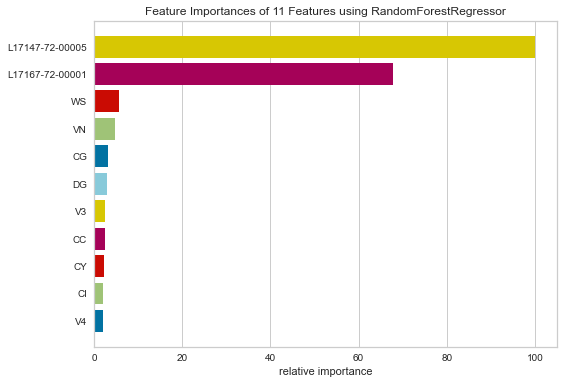

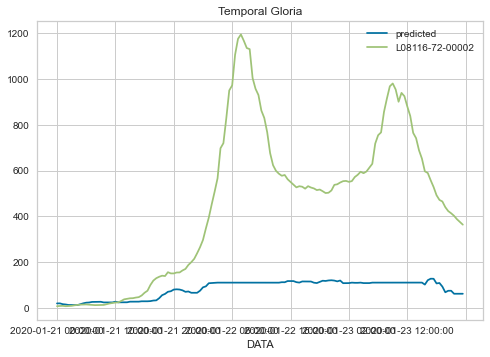

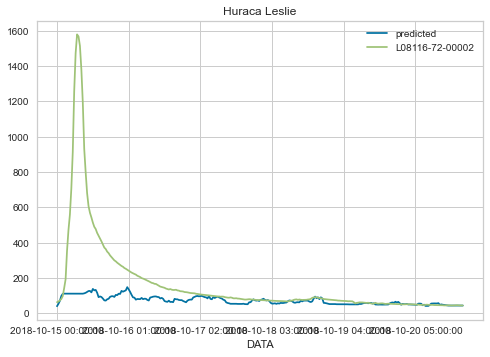

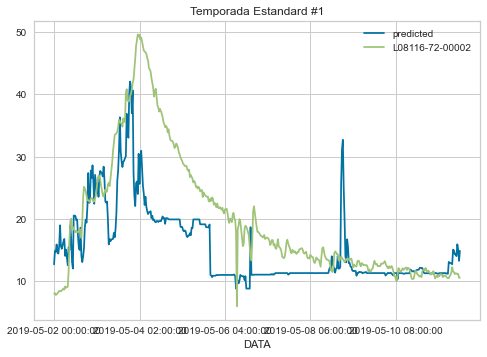

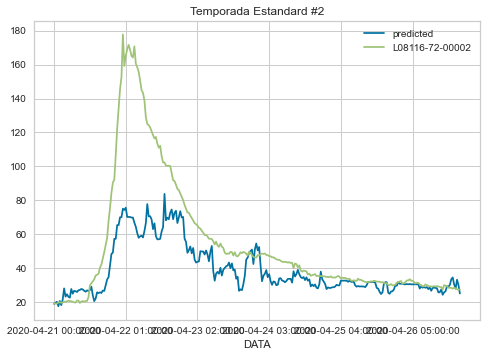

Iteració:  2
CPU times: total: 10.3 s
Wall time: 35.6 s


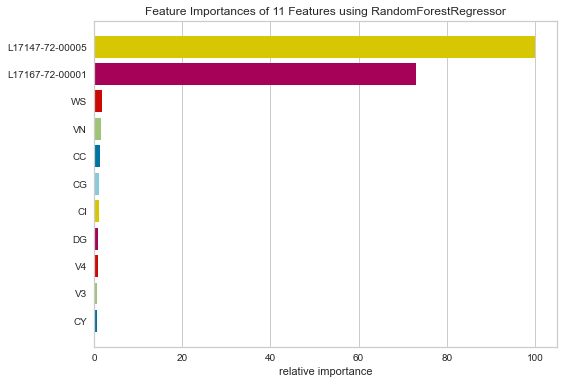

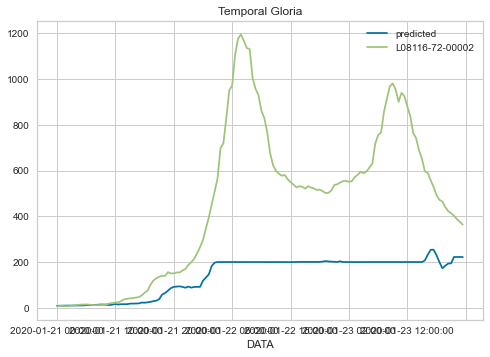

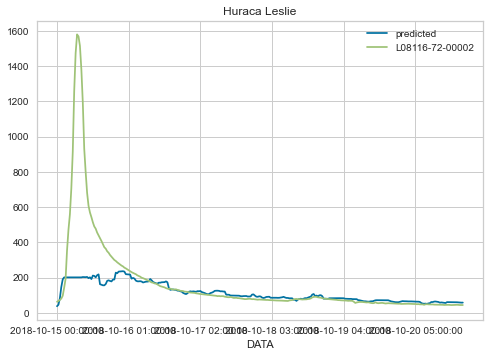

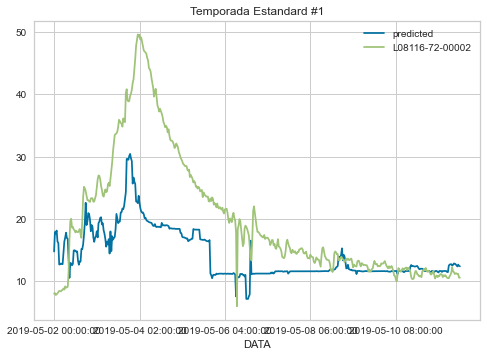

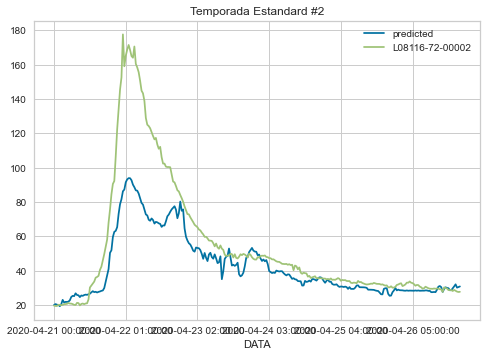

Iteració:  3
CPU times: total: 16.6 s
Wall time: 59.1 s


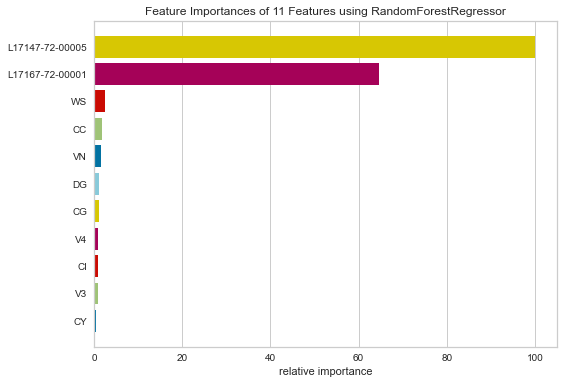

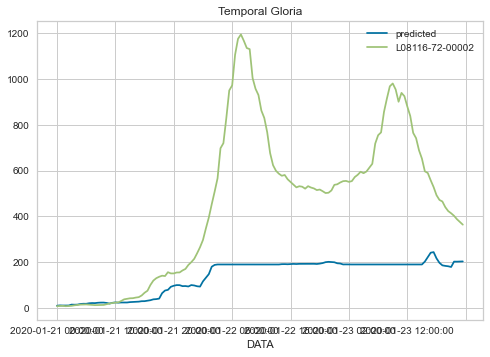

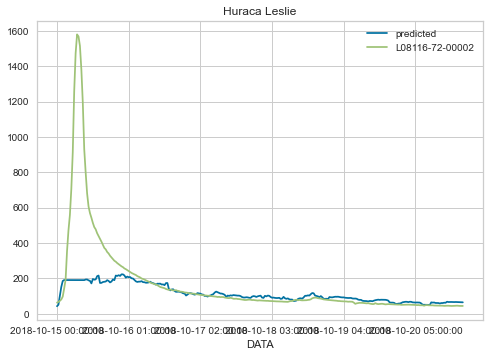

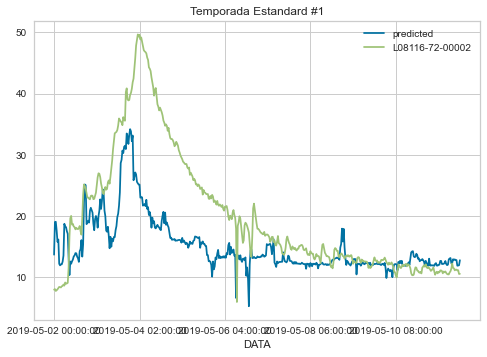

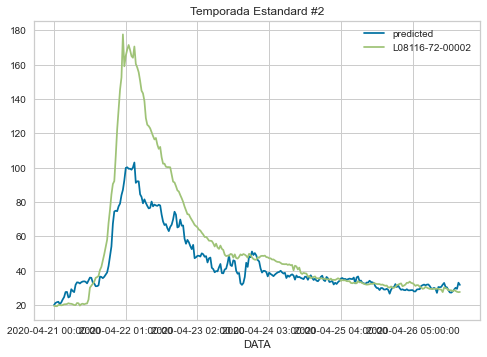

Time:  0:01:53.906866


In [22]:
start = timeit.default_timer()

tscv = TimeSeriesSplit(n_splits=3)
param_search = { 
    'n_estimators': [50,100, 200], # Nombre de arbres
    'max_features': [1, 'sqrt', 'log2'], # Maxim features
    'max_depth' : [8,10,25,None] # Profunditat dels arbres
}

iteracio = 0
for train_index, test_index in tscv.split(Df_AltX):
    iteracio += 1
    Df_AltX_train, Df_AltX_test = Df_AltX.values[train_index], Df_AltX.values[test_index]
    Df_Alty_train, Df_Alty_test = Df_Alty.values.ravel()[train_index], Df_Alty.values.ravel()[test_index]

    model = RandomForestRegressor()
    tscv = TimeSeriesSplit()
    gsearch = HalvingGridSearchCV(estimator=model, cv=tscv, param_grid=param_search, n_jobs=-1)
    print("Iteració: ", iteracio)
    %time gsearchfited = gsearch.fit(Df_AltX_train, Df_Alty_train)
        
    bestParams = gsearchfited.best_params_
    score = gsearchfited.score(Df_AltX_test, Df_Alty_test)
    FeatureImportance = gsearchfited.best_estimator_.feature_importances_
    
    predicty = gsearchfited.best_estimator_.predict(Df_AltX_test)
    rmseScore = mean_squared_error(Df_Alty_test, predicty, squared=False)
    
    nameh = Df_AltX.columns[0]
    hores = "1 day"
   
    viz = FeatureImportances(gsearchfited.best_estimator_)
    viz.fit(Df_AltX, Df_Alty)
    viz.show()
    
    plotYtestAnomaly1 = dataPredictionsY["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotYtestAnomaly2 = dataPredictionsY["2018-10-14 5:00:00":"2018-10-20 21:30:00"]
    plotYtestStandard1 = dataPredictionsY["2019-05-01 5:00:00":"2019-05-11 21:30:00"]
    plotYtestStandard2 = dataPredictionsY["2020-04-20 5:00:00":"2020-04-26 21:30:00"]
    
    plotXtestAnomaly1 = dataPredictionsX["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotXtestAnomaly2 = dataPredictionsX["2018-10-14 5:00:00":"2018-10-20 21:30:00"]
    plotXtestStandard1 = dataPredictionsX["2019-05-01 5:00:00":"2019-05-11 21:30:00"]
    plotXtestStandard2 = dataPredictionsX["2020-04-20 5:00:00":"2020-04-26 21:30:00"]
    

    
    predictAnomaly1 = gsearchfited.best_estimator_.predict(plotXtestAnomaly1.values)
    predictAnomaly2 = gsearchfited.best_estimator_.predict(plotXtestAnomaly2.values)
    predictStandard1 = gsearchfited.best_estimator_.predict(plotXtestStandard1.values)
    predictStandard2 = gsearchfited.best_estimator_.predict(plotXtestStandard2.values)
    
    rmseScoreAnomaly1 = mean_squared_error(plotYtestAnomaly1, predictAnomaly1, squared=False)
    rmseScoreAnomaly2 = mean_squared_error(plotYtestAnomaly2, predictAnomaly2, squared=False)
    rmseScoreStandard1 = mean_squared_error(plotYtestStandard1, predictStandard1, squared=False)
    rmseScoreStandard2 = mean_squared_error(plotYtestStandard2, predictStandard2, squared=False)
    
    plotYtestAnomaly1.insert(0, 'predicted', predictAnomaly1, allow_duplicates=True)
    plotYtestAnomaly2.insert(0, 'predicted', predictAnomaly2, allow_duplicates=True)
    plotYtestStandard1.insert(0, 'predicted', predictStandard1, allow_duplicates=True)
    plotYtestStandard2.insert(0, 'predicted', predictStandard2, allow_duplicates=True)
    
    new_row = {'Method':'Random Forest','RMSE Total':rmseScore, 'Score':score,"Prediccio_Hores":hores,
              'RSME_Gloria':rmseScoreAnomaly1, 'RMSE_Leslie':rmseScoreAnomaly2,'RMSE_Standard1':rmseScoreStandard1,'RMSE_Standard2':rmseScoreStandard2}
    df_results_altTer = df_results_altTer.append(new_row, ignore_index=True)

    plotYtestAnomaly1.plot(title="Temporal Gloria")
    plotYtestAnomaly2.plot(title="Huraca Leslie")
    plotYtestStandard1.plot(title="Temporada Estandard #1")
    plotYtestStandard2.plot(title="Temporada Estandard #2")
    plt.show()

    
stop = timeit.default_timer()
print("Time: ", str(datetime.timedelta(seconds=(stop-start))))

# XGBoost (Alt Ter)

Iteració:  1
[13:34:00] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


CPU times: total: 5.8 s
Wall time: 10.6 s


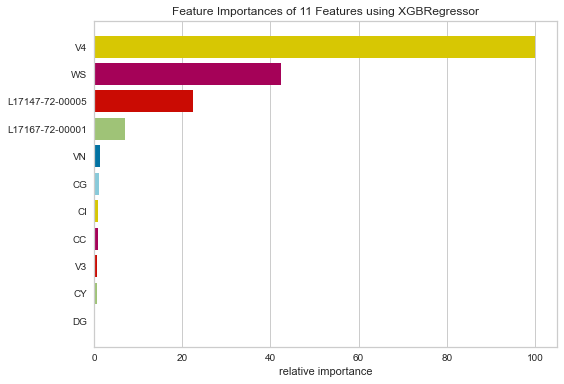

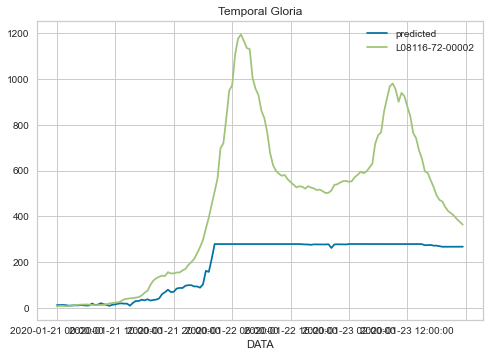

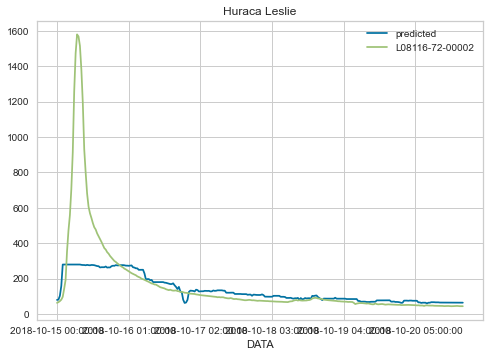

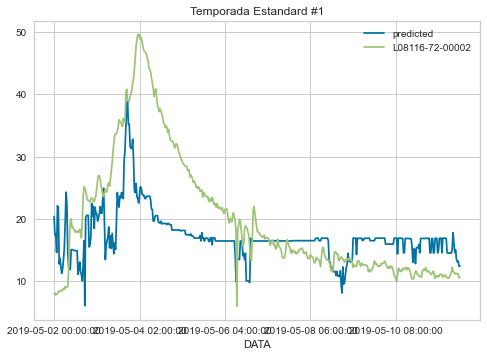

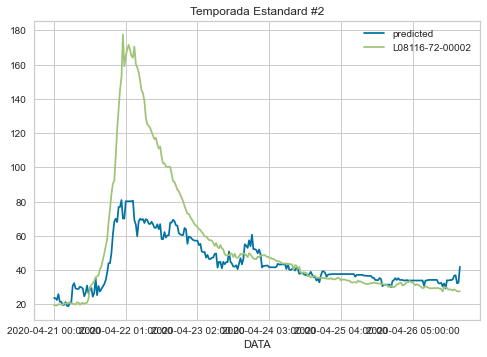

Iteració:  2
[13:34:20] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


CPU times: total: 9.36 s
Wall time: 19.9 s


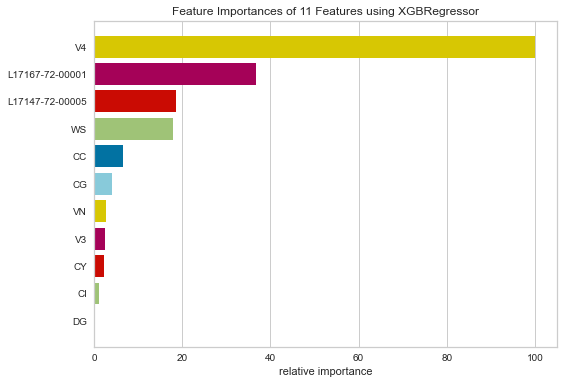

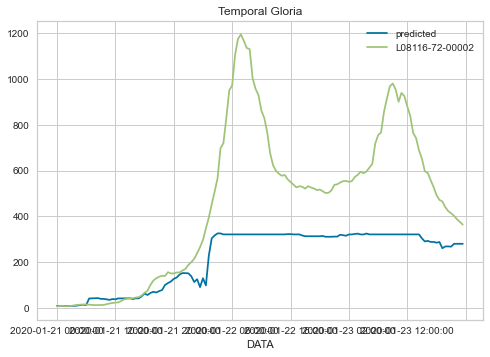

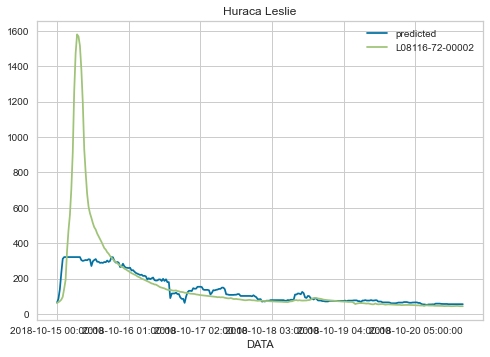

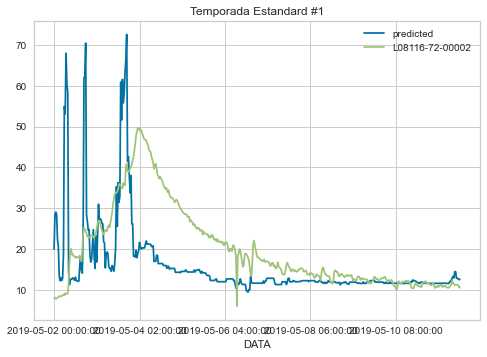

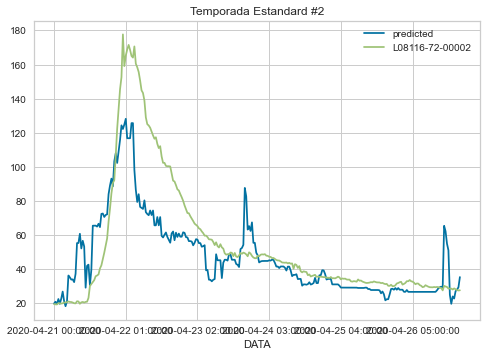

Iteració:  3
[13:34:52] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


CPU times: total: 13.2 s
Wall time: 31.5 s


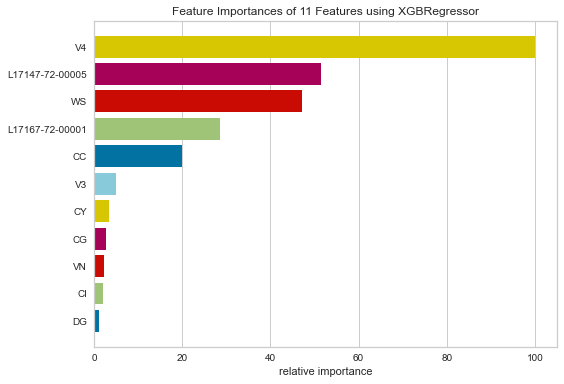

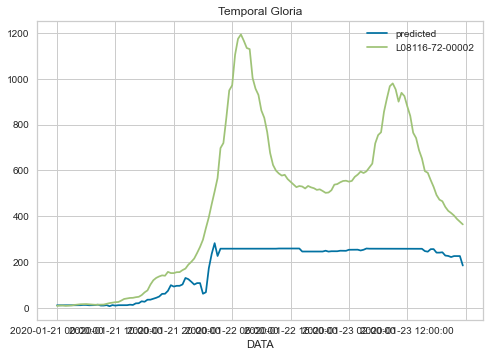

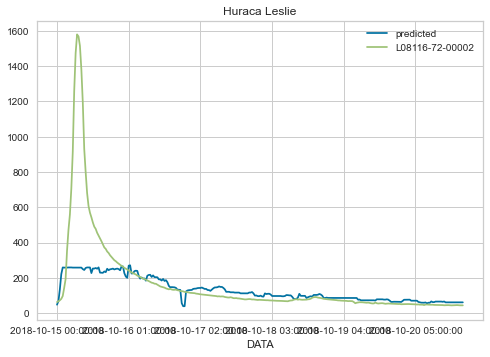

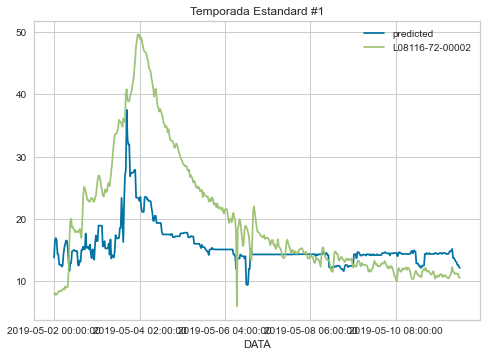

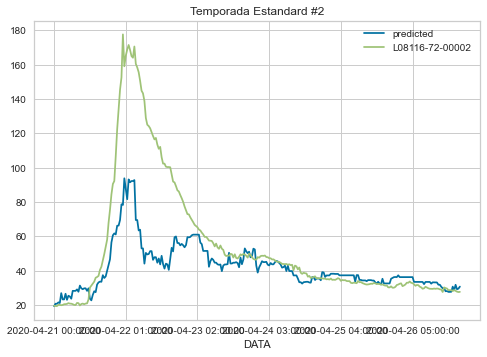

Time:  0:01:03.881553


In [23]:
start = timeit.default_timer()

tscv = TimeSeriesSplit(n_splits=3)
param_search = { 
    'n_estimators': [50,100, 200], # Nombre de arbres
    'max_features': [1, 'sqrt', 'log2'], # Maxim features
    'max_depth' : [8,10,25,None] # Profunditat dels arbres
}

iteracio = 0
for train_index, test_index in tscv.split(Df_AltX):
    iteracio += 1
    Df_AltX_train, Df_AltX_test = Df_AltX.values[train_index], Df_AltX.values[test_index]
    Df_Alty_train, Df_Alty_test = Df_Alty.values.ravel()[train_index], Df_Alty.values.ravel()[test_index]

    model = xgb.XGBRegressor()
    tscv = TimeSeriesSplit()
    gsearch = HalvingGridSearchCV(estimator=model, cv=tscv, param_grid=param_search, n_jobs=-1)
    print("Iteració: ", iteracio)
    %time gsearchfited = gsearch.fit(Df_AltX_train, Df_Alty_train)
        
    bestParams = gsearchfited.best_params_
    score = gsearchfited.score(Df_AltX_test, Df_Alty_test)
    FeatureImportance = gsearchfited.best_estimator_.feature_importances_
    
    predicty = gsearchfited.best_estimator_.predict(Df_AltX_test)
    rmseScore = mean_squared_error(Df_Alty_test, predicty, squared=False)
    
    nameh = Df_AltX.columns[0]
    hores = "1 day"

    viz = FeatureImportances(gsearchfited.best_estimator_)
    viz.fit(Df_AltX, Df_Alty)
    viz.show()
    
    plotYtestAnomaly1 = dataPredictionsY["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotYtestAnomaly2 = dataPredictionsY["2018-10-14 5:00:00":"2018-10-20 21:30:00"]
    plotYtestStandard1 = dataPredictionsY["2019-05-01 5:00:00":"2019-05-11 21:30:00"]
    plotYtestStandard2 = dataPredictionsY["2020-04-20 5:00:00":"2020-04-26 21:30:00"]
    
    plotXtestAnomaly1 = dataPredictionsX["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotXtestAnomaly2 = dataPredictionsX["2018-10-14 5:00:00":"2018-10-20 21:30:00"]
    plotXtestStandard1 = dataPredictionsX["2019-05-01 5:00:00":"2019-05-11 21:30:00"]
    plotXtestStandard2 = dataPredictionsX["2020-04-20 5:00:00":"2020-04-26 21:30:00"]
    
    
    predictAnomaly1 = gsearchfited.best_estimator_.predict(plotXtestAnomaly1.values)
    predictAnomaly2 = gsearchfited.best_estimator_.predict(plotXtestAnomaly2.values)
    predictStandard1 = gsearchfited.best_estimator_.predict(plotXtestStandard1.values)
    predictStandard2 = gsearchfited.best_estimator_.predict(plotXtestStandard2.values)
    
    rmseScoreAnomaly1 = mean_squared_error(plotYtestAnomaly1, predictAnomaly1, squared=False)
    rmseScoreAnomaly2 = mean_squared_error(plotYtestAnomaly2, predictAnomaly2, squared=False)
    rmseScoreStandard1 = mean_squared_error(plotYtestStandard1, predictStandard1, squared=False)
    rmseScoreStandard2 = mean_squared_error(plotYtestStandard2, predictStandard2, squared=False)
    
    
    
    plotYtestAnomaly1.insert(0, 'predicted', predictAnomaly1, allow_duplicates=True)
    plotYtestAnomaly2.insert(0, 'predicted', predictAnomaly2, allow_duplicates=True)
    plotYtestStandard1.insert(0, 'predicted', predictStandard1, allow_duplicates=True)
    plotYtestStandard2.insert(0, 'predicted', predictStandard2, allow_duplicates=True)

    new_row = {'Method':'XGBoost','RMSE Total':rmseScore, 'Score':score,"Prediccio_Hores":hores,
              'RSME_Gloria':rmseScoreAnomaly1, 'RMSE_Leslie':rmseScoreAnomaly2,'RMSE_Standard1':rmseScoreStandard1,'RMSE_Standard2':rmseScoreStandard2}
    df_results_altTer = df_results_altTer.append(new_row, ignore_index=True)

    plotYtestAnomaly1.plot(title="Temporal Gloria")
    plotYtestAnomaly2.plot(title="Huraca Leslie")
    plotYtestStandard1.plot(title="Temporada Estandard #1")
    plotYtestStandard2.plot(title="Temporada Estandard #2")
    plt.show()
    
stop = timeit.default_timer()
print("Time: ", str(datetime.timedelta(seconds=(stop-start))))

## LightGBM (Alt Ter)

2012-01-07 03:00:00


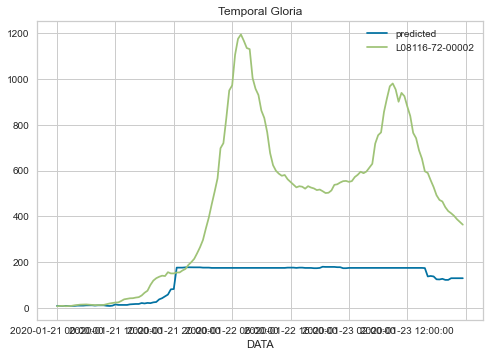

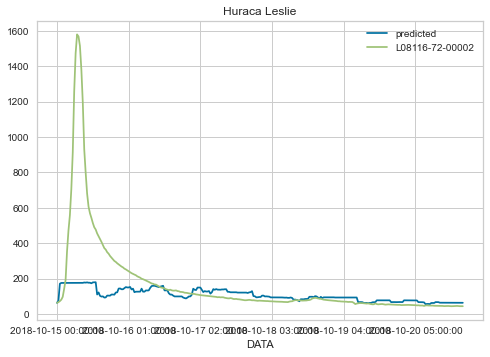

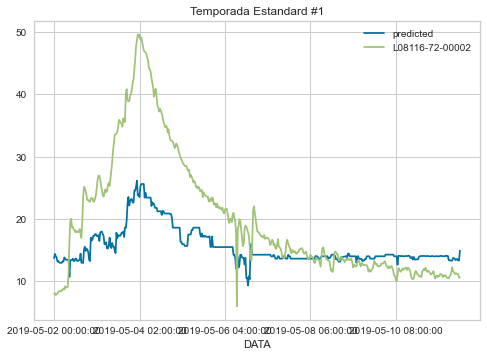

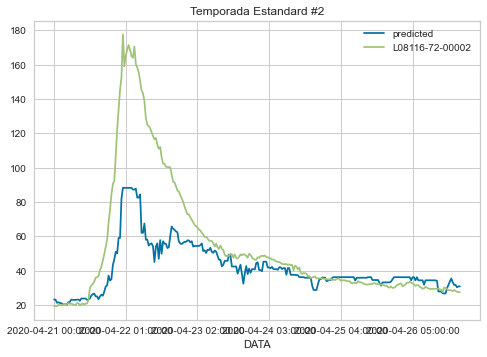

2015-01-03 00:00:00


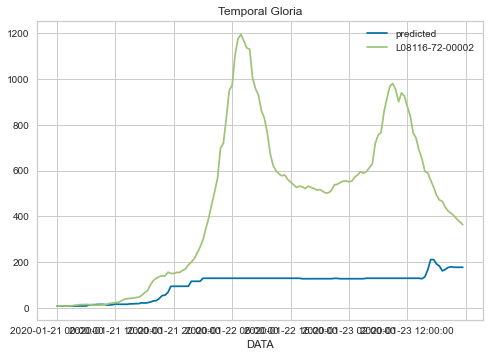

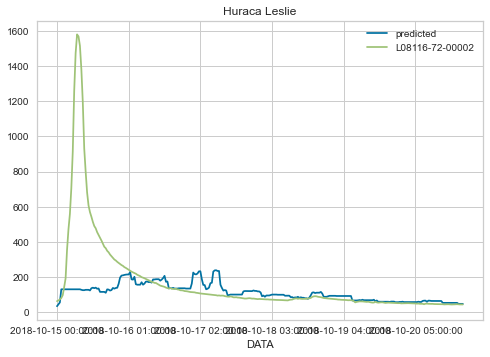

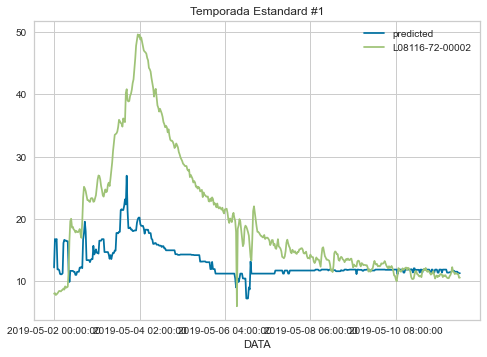

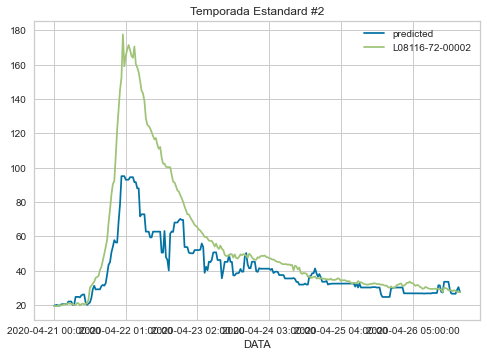

2017-12-17 01:30:00


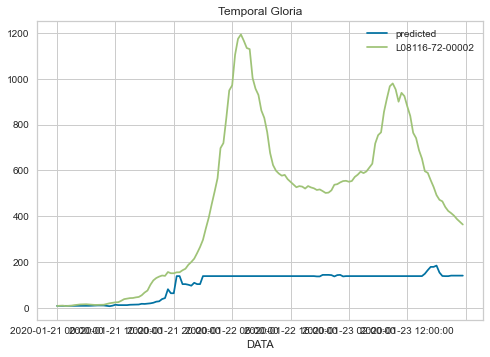

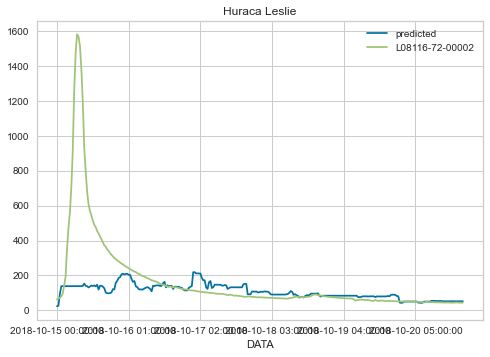

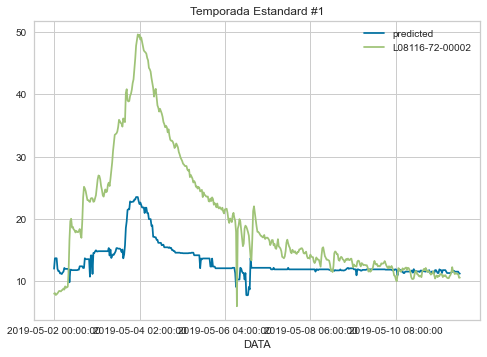

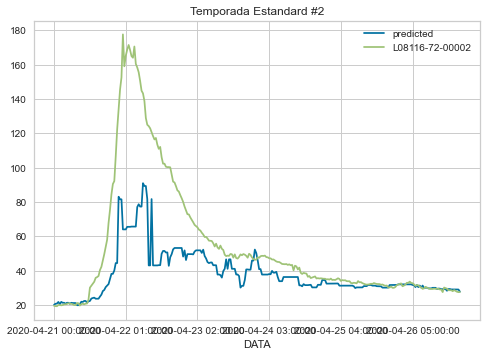

Time:  0:00:01.708864


In [24]:
start = timeit.default_timer()

tscv = TimeSeriesSplit(n_splits=3)
param_search = {
                        "objective": "regression",
                        "metric": "rmse",
                        "verbosity": -1,
                        "boosting_type": "gbdt",
                        "seed": 42,
                        'linear_tree': False,
                        'learning_rate': .15,
                        'min_child_samples': 5,
                        'num_leaves': 31,
                        'num_iterations': 50
                    }

iteracio = 0
for train_index, test_index in tscv.split(Df_AltX):
    iteracio += 1
    Df_AltX_train, Df_AltX_test = Df_AltX.values[train_index], Df_AltX.values[test_index]
    Df_Alty_train, Df_Alty_test = Df_Alty.values.ravel()[train_index], Df_Alty.values.ravel()[test_index]
    
    print(Df_AltX.iloc[test_index].index[0])

    model = lgb.LGBMRegressor(first_metric_only = True, **param_search)
    
    model.fit(Df_AltX_train, Df_Alty_train,
          eval_metric = 'l1', 
          eval_set = [(Df_AltX_test, Df_Alty_test)],
          #early_stopping_rounds = 10,
          verbose = 0)
    predicty = model.predict(Df_AltX_test)
    rmseScore = mean_squared_error(Df_Alty_test, predicty, squared=False)
    
    nameh = Df_AltX.columns[0]
    hores = "1 day"
    
    
    
    #joblib.dump(gsearchfited.best_estimator_, 'resultsDf/pickle/partAlta/XGBoost_'+str(df_results_altTer.index[-1])+'.pkl', compress = 1)

    #viz = FeatureImportances(gsearchfited.best_estimator_)
    #viz.fit(Df_AltX, Df_Alty)
    #viz.show()
    
    plotYtestAnomaly1 = dataPredictionsY["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotYtestAnomaly2 = dataPredictionsY["2018-10-14 5:00:00":"2018-10-20 21:30:00"]
    plotYtestStandard1 = dataPredictionsY["2019-05-01 5:00:00":"2019-05-11 21:30:00"]
    plotYtestStandard2 = dataPredictionsY["2020-04-20 5:00:00":"2020-04-26 21:30:00"]
    
    plotXtestAnomaly1 = dataPredictionsX["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotXtestAnomaly2 = dataPredictionsX["2018-10-14 5:00:00":"2018-10-20 21:30:00"]
    plotXtestStandard1 = dataPredictionsX["2019-05-01 5:00:00":"2019-05-11 21:30:00"]
    plotXtestStandard2 = dataPredictionsX["2020-04-20 5:00:00":"2020-04-26 21:30:00"]
    

    
    predictAnomaly1 = model.predict(plotXtestAnomaly1.values)
    predictAnomaly2 = model.predict(plotXtestAnomaly2.values)
    predictStandard1 = model.predict(plotXtestStandard1.values)
    predictStandard2 = model.predict(plotXtestStandard2.values)
    
    rmseScoreAnomaly1 = mean_squared_error(plotYtestAnomaly1, predictAnomaly1, squared=False)
    rmseScoreAnomaly2 = mean_squared_error(plotYtestAnomaly2, predictAnomaly2, squared=False)
    rmseScoreStandard1 = mean_squared_error(plotYtestStandard1, predictStandard1, squared=False)
    rmseScoreStandard2 = mean_squared_error(plotYtestStandard2, predictStandard2, squared=False)
    
    plotYtestAnomaly1.insert(0, 'predicted', predictAnomaly1, allow_duplicates=True)
    plotYtestAnomaly2.insert(0, 'predicted', predictAnomaly2, allow_duplicates=True)
    plotYtestStandard1.insert(0, 'predicted', predictStandard1, allow_duplicates=True)
    plotYtestStandard2.insert(0, 'predicted', predictStandard2, allow_duplicates=True)
    
    new_row = {'Method':'LightGBM','RMSE Total':rmseScore,'Score':None,"Prediccio_Hores":hores,
              'RSME_Gloria':rmseScoreAnomaly1, 'RMSE_Leslie':rmseScoreAnomaly2,'RMSE_Standard1':rmseScoreStandard1,'RMSE_Standard2':rmseScoreStandard2}
    df_results_altTer = df_results_altTer.append(new_row, ignore_index=True)

    plotYtestAnomaly1.plot(title="Temporal Gloria")
    plotYtestAnomaly2.plot(title="Huraca Leslie")
    plotYtestStandard1.plot(title="Temporada Estandard #1")
    plotYtestStandard2.plot(title="Temporada Estandard #2")
    plt.show()

    
stop = timeit.default_timer()
print("Time: ", str(datetime.timedelta(seconds=(stop-start))))

# CatBoost (Alt Ter)

2012-01-07 03:00:00


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

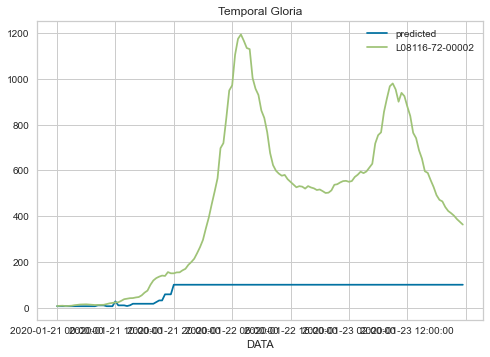

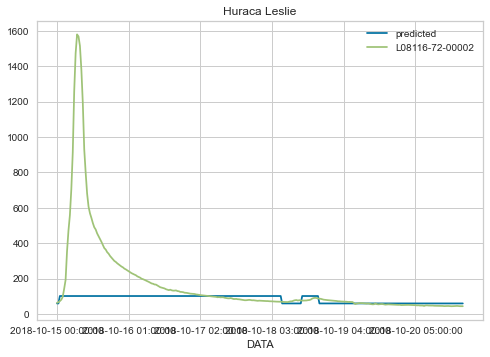

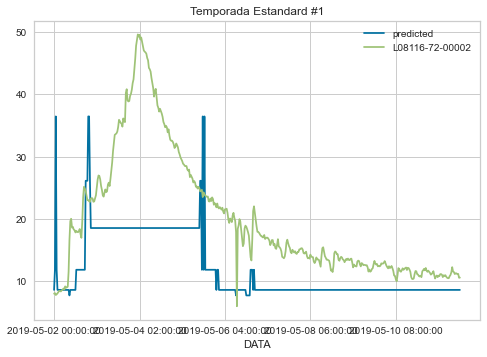

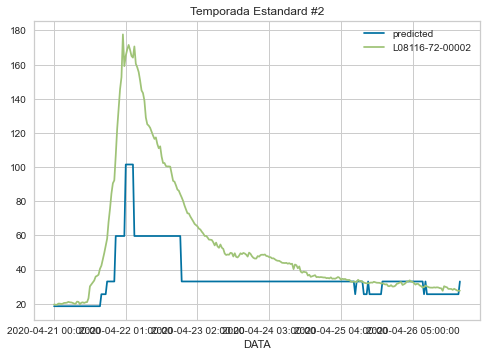

2015-01-03 00:00:00


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

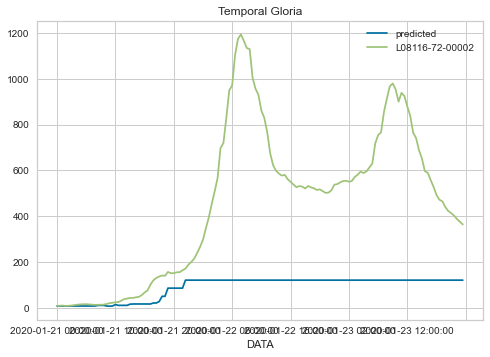

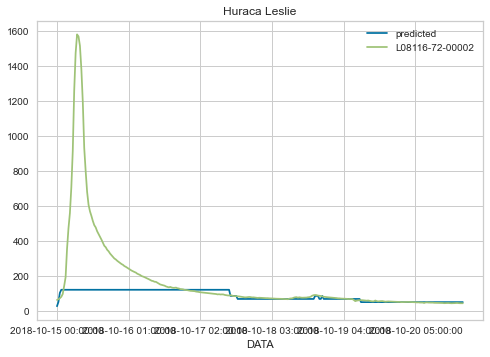

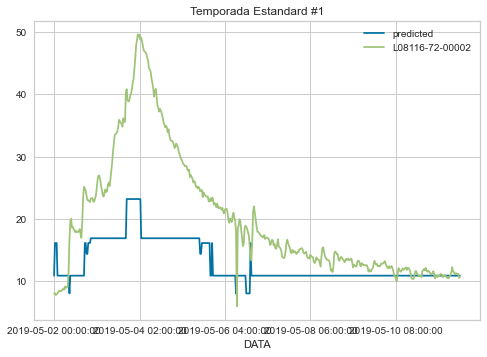

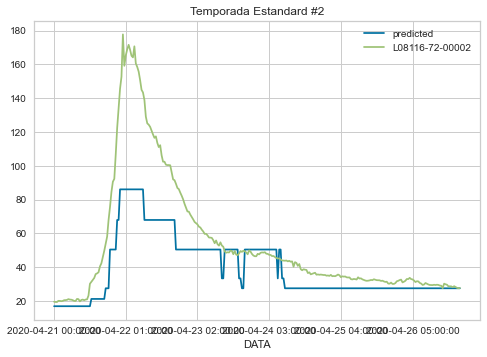

2017-12-17 01:30:00


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

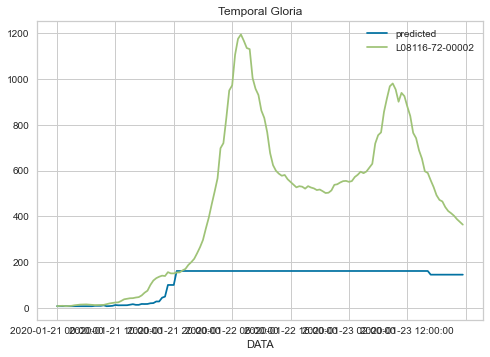

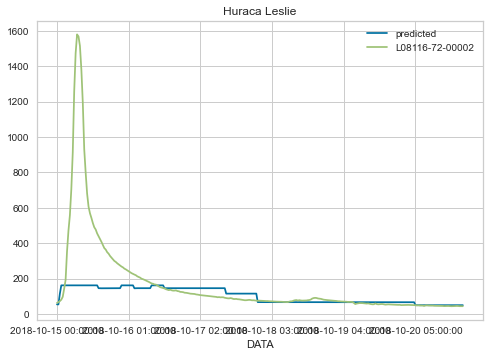

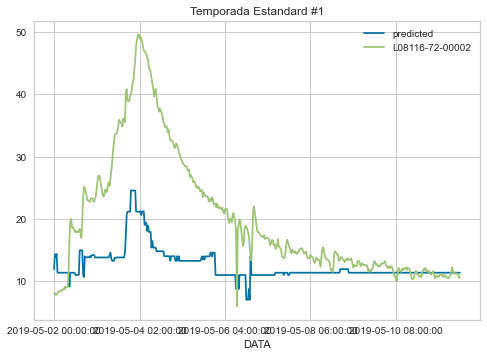

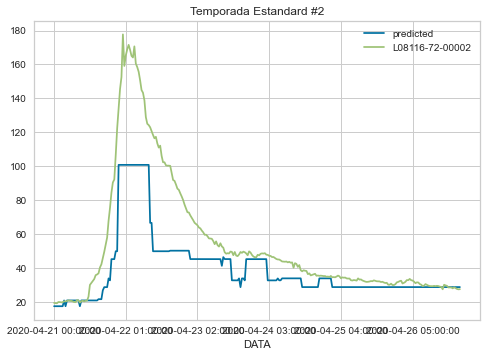

Time:  0:00:04.439036


In [25]:
start = timeit.default_timer()

tscv = TimeSeriesSplit(n_splits=3)
param_search = {
    'n_estimators': 2000,
    'max_depth': 4,
    'num_leaves': 2**4,
    'learning_rate': 0.1,
    'boosting_type': 'dart'
}


iteracio = 0
for train_index, test_index in tscv.split(Df_AltX):
    iteracio += 1
    Df_AltX_train, Df_AltX_test = Df_AltX.values[train_index], Df_AltX.values[test_index]
    Df_Alty_train, Df_Alty_test = Df_Alty.values.ravel()[train_index], Df_Alty.values.ravel()[test_index]
    
    print(Df_AltX.iloc[test_index].index[0])

    model = CatBoostRegressor(loss_function='RMSE', depth=3, learning_rate=0.4, iterations=1000, 
    random_seed=18, 
    od_type='Iter',
    od_wait=20)
    
    model.fit(Df_AltX_train, Df_Alty_train,
          use_best_model=True, 
          eval_set = (Df_AltX_test, Df_Alty_test),
          #early_stopping_rounds = 10,
          verbose = 0,
        plot=True)
    predicty = model.predict(Df_AltX_test)
    rmseScore = mean_squared_error(Df_Alty_test, predicty, squared=False)
    
    nameh = Df_AltX.columns[0]
    hores = "1 day"
    
    
    
    #joblib.dump(gsearchfited.best_estimator_, 'resultsDf/pickle/partAlta/XGBoost_'+str(df_results_altTer.index[-1])+'.pkl', compress = 1)

    #viz = FeatureImportances(gsearchfited.best_estimator_)
    #viz.fit(Df_AltX, Df_Alty)
    #viz.show()
    
    plotYtestAnomaly1 = dataPredictionsY["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotYtestAnomaly2 = dataPredictionsY["2018-10-14 5:00:00":"2018-10-20 21:30:00"]
    plotYtestStandard1 = dataPredictionsY["2019-05-01 5:00:00":"2019-05-11 21:30:00"]
    plotYtestStandard2 = dataPredictionsY["2020-04-20 5:00:00":"2020-04-26 21:30:00"]
    
    plotXtestAnomaly1 = dataPredictionsX["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotXtestAnomaly2 = dataPredictionsX["2018-10-14 5:00:00":"2018-10-20 21:30:00"]
    plotXtestStandard1 = dataPredictionsX["2019-05-01 5:00:00":"2019-05-11 21:30:00"]
    plotXtestStandard2 = dataPredictionsX["2020-04-20 5:00:00":"2020-04-26 21:30:00"]
    

    
    predictAnomaly1 = model.predict(plotXtestAnomaly1.values)
    predictAnomaly2 = model.predict(plotXtestAnomaly2.values)
    predictStandard1 = model.predict(plotXtestStandard1.values)
    predictStandard2 = model.predict(plotXtestStandard2.values)
    
    rmseScoreAnomaly1 = mean_squared_error(plotYtestAnomaly1, predictAnomaly1, squared=False)
    rmseScoreAnomaly2 = mean_squared_error(plotYtestAnomaly2, predictAnomaly2, squared=False)
    rmseScoreStandard1 = mean_squared_error(plotYtestStandard1, predictStandard1, squared=False)
    rmseScoreStandard2 = mean_squared_error(plotYtestStandard2, predictStandard2, squared=False)
    
    plotYtestAnomaly1.insert(0, 'predicted', predictAnomaly1, allow_duplicates=True)
    plotYtestAnomaly2.insert(0, 'predicted', predictAnomaly2, allow_duplicates=True)
    plotYtestStandard1.insert(0, 'predicted', predictStandard1, allow_duplicates=True)
    plotYtestStandard2.insert(0, 'predicted', predictStandard2, allow_duplicates=True)
    
    new_row = {'Method':'CatBoost','RMSE Total':rmseScore,'Score':None,"Prediccio_Hores":hores,
              'RSME_Gloria':rmseScoreAnomaly1, 'RMSE_Leslie':rmseScoreAnomaly2,'RMSE_Standard1':rmseScoreStandard1,'RMSE_Standard2':rmseScoreStandard2}
    df_results_altTer = df_results_altTer.append(new_row, ignore_index=True)

    plotYtestAnomaly1.plot(title="Temporal Gloria")
    plotYtestAnomaly2.plot(title="Huraca Leslie")
    plotYtestStandard1.plot(title="Temporada Estandard #1")
    plotYtestStandard2.plot(title="Temporada Estandard #2")
    plt.show()

    
stop = timeit.default_timer()
print("Time: ", str(datetime.timedelta(seconds=(stop-start))))

# ExtraTrees (Alt Ter)

Iteració:  1
CPU times: total: 1.03 s
Wall time: 7.53 s


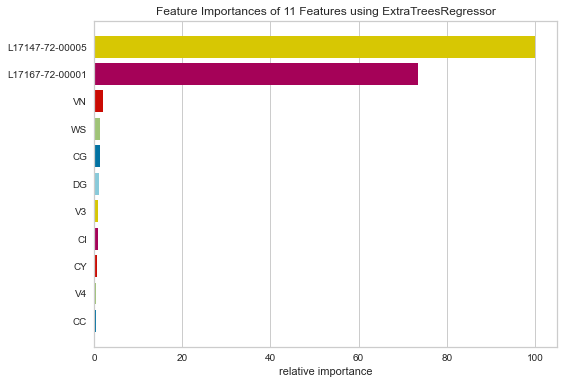

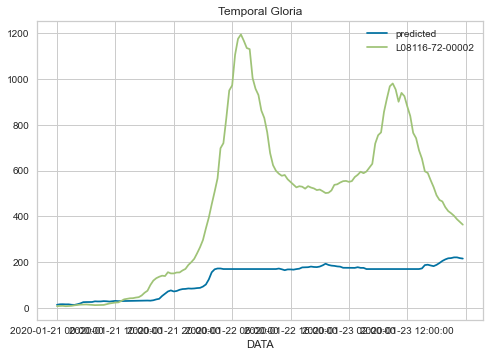

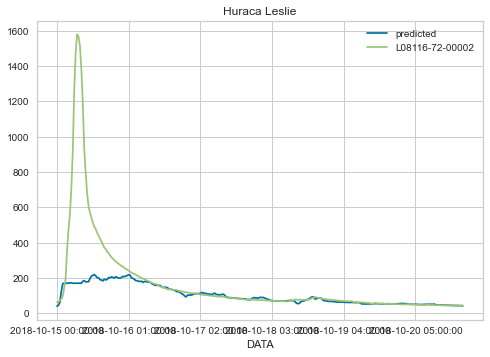

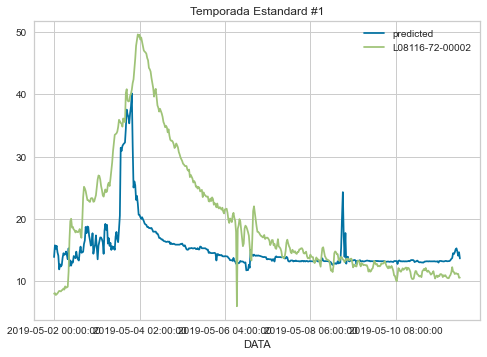

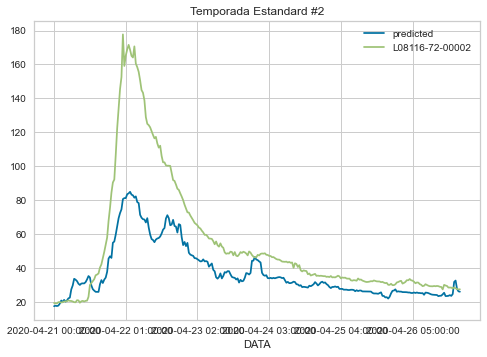

Iteració:  2
CPU times: total: 2.73 s
Wall time: 13.1 s


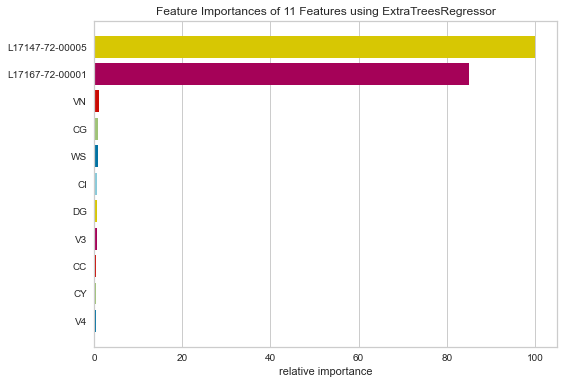

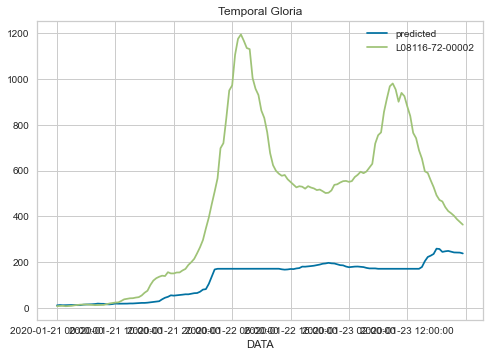

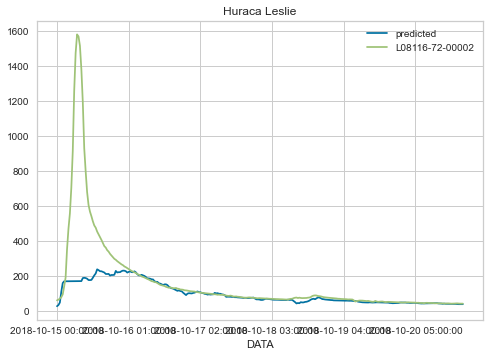

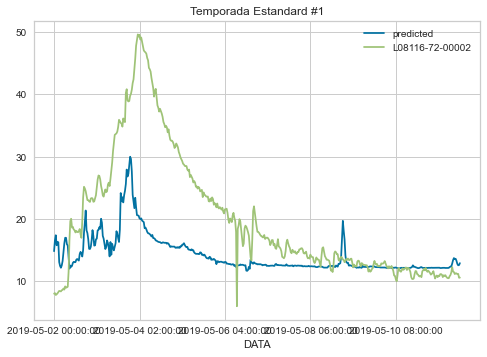

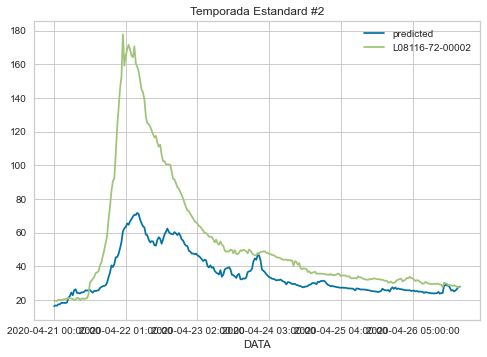

Iteració:  3
CPU times: total: 3.89 s
Wall time: 21.5 s


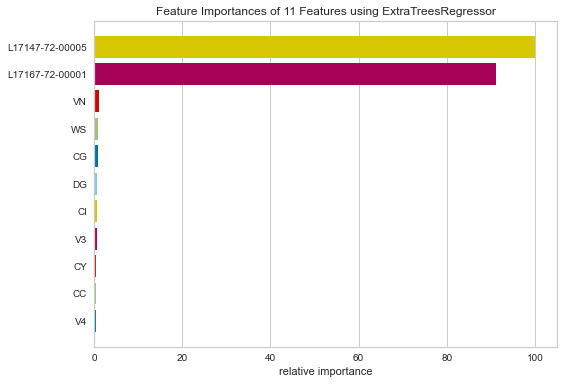

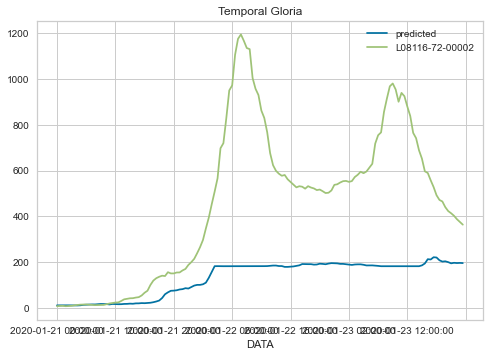

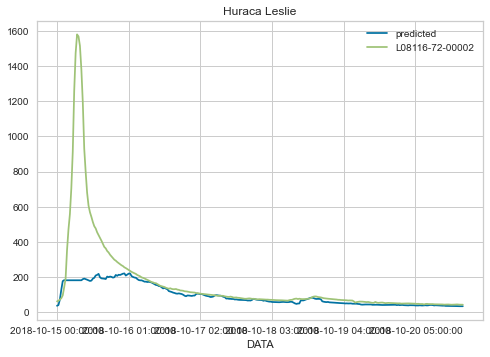

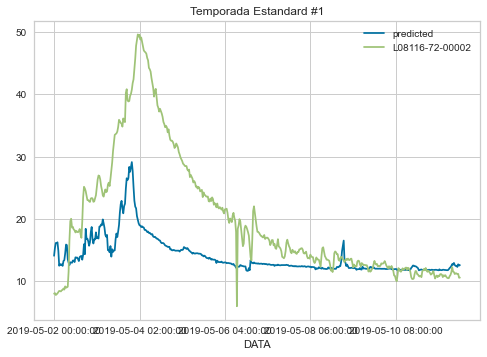

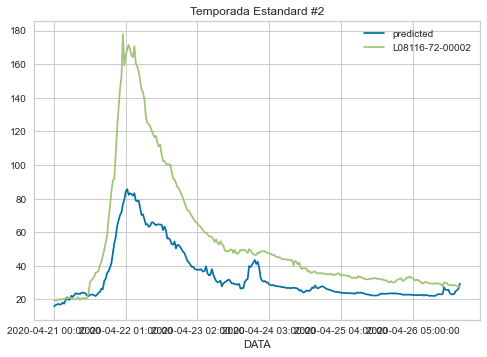

Time:  0:00:44.875436


In [26]:
start = timeit.default_timer()

tscv = TimeSeriesSplit(n_splits=3)
param_search = { 
    'n_estimators': [50,100, 200], # Nombre de arbres
    'max_features': [1, 'sqrt', 'log2'], # Maxim features
    'max_depth' : [8,10,25,None] # Profunditat dels arbres
}

iteracio = 0
for train_index, test_index in tscv.split(Df_AltX):
    iteracio += 1
    Df_AltX_train, Df_AltX_test = Df_AltX.values[train_index], Df_AltX.values[test_index]
    Df_Alty_train, Df_Alty_test = Df_Alty.values.ravel()[train_index], Df_Alty.values.ravel()[test_index]

    model = ExtraTreesRegressor()
    tscv = TimeSeriesSplit()
    gsearch = HalvingGridSearchCV(estimator=model, cv=tscv, param_grid=param_search, n_jobs=-1)
    print("Iteració: ", iteracio)
    %time gsearchfited = gsearch.fit(Df_AltX_train, Df_Alty_train)
        
    bestParams = gsearchfited.best_params_
    score = gsearchfited.score(Df_AltX_test, Df_Alty_test)
    FeatureImportance = gsearchfited.best_estimator_.feature_importances_
    
    predicty = gsearchfited.best_estimator_.predict(Df_AltX_test)
    rmseScore = mean_squared_error(Df_Alty_test, predicty, squared=False)
    
    nameh = Df_AltX.columns[0]
    hores = "1 day"
    
   
    

    viz = FeatureImportances(gsearchfited.best_estimator_)
    viz.fit(Df_AltX, Df_Alty)
    viz.show()
    
    plotYtestAnomaly1 = dataPredictionsY["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotYtestAnomaly2 = dataPredictionsY["2018-10-14 5:00:00":"2018-10-20 21:30:00"]
    plotYtestStandard1 = dataPredictionsY["2019-05-01 5:00:00":"2019-05-11 21:30:00"]
    plotYtestStandard2 = dataPredictionsY["2020-04-20 5:00:00":"2020-04-26 21:30:00"]
    
    plotXtestAnomaly1 = dataPredictionsX["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotXtestAnomaly2 = dataPredictionsX["2018-10-14 5:00:00":"2018-10-20 21:30:00"]
    plotXtestStandard1 = dataPredictionsX["2019-05-01 5:00:00":"2019-05-11 21:30:00"]
    plotXtestStandard2 = dataPredictionsX["2020-04-20 5:00:00":"2020-04-26 21:30:00"]
    

    
    predictAnomaly1 = gsearchfited.best_estimator_.predict(plotXtestAnomaly1.values)
    predictAnomaly2 = gsearchfited.best_estimator_.predict(plotXtestAnomaly2.values)
    predictStandard1 = gsearchfited.best_estimator_.predict(plotXtestStandard1.values)
    predictStandard2 = gsearchfited.best_estimator_.predict(plotXtestStandard2.values)
    
    rmseScoreAnomaly1 = mean_squared_error(plotYtestAnomaly1, predictAnomaly1, squared=False)
    rmseScoreAnomaly2 = mean_squared_error(plotYtestAnomaly2, predictAnomaly2, squared=False)
    rmseScoreStandard1 = mean_squared_error(plotYtestStandard1, predictStandard1, squared=False)
    rmseScoreStandard2 = mean_squared_error(plotYtestStandard2, predictStandard2, squared=False)
    
    plotYtestAnomaly1.insert(0, 'predicted', predictAnomaly1, allow_duplicates=True)
    plotYtestAnomaly2.insert(0, 'predicted', predictAnomaly2, allow_duplicates=True)
    plotYtestStandard1.insert(0, 'predicted', predictStandard1, allow_duplicates=True)
    plotYtestStandard2.insert(0, 'predicted', predictStandard2, allow_duplicates=True)
    
    new_row = {'Method':'Extra Trees','RMSE Total':rmseScore, 'Score':score,"Prediccio_Hores":hores,
              'RSME_Gloria':rmseScoreAnomaly1, 'RMSE_Leslie':rmseScoreAnomaly2,'RMSE_Standard1':rmseScoreStandard1,'RMSE_Standard2':rmseScoreStandard2}
    df_results_altTer = df_results_altTer.append(new_row, ignore_index=True)

    plotYtestAnomaly1.plot(title="Temporal Gloria")
    plotYtestAnomaly2.plot(title="Huraca Leslie")
    plotYtestStandard1.plot(title="Temporada Estandard #1")
    plotYtestStandard2.plot(title="Temporada Estandard #2")
    plt.show()

    
stop = timeit.default_timer()
print("Time: ", str(datetime.timedelta(seconds=(stop-start))))

# Linear Regression (Alt Ter)

Iteració:  1
CPU times: total: 93.8 ms
Wall time: 184 ms


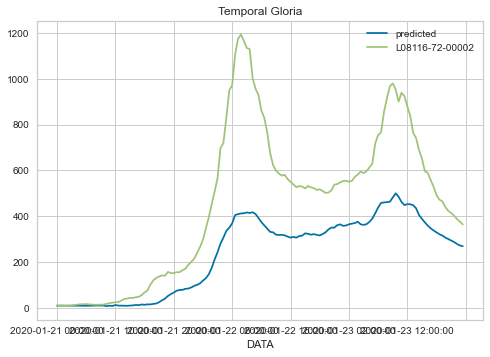

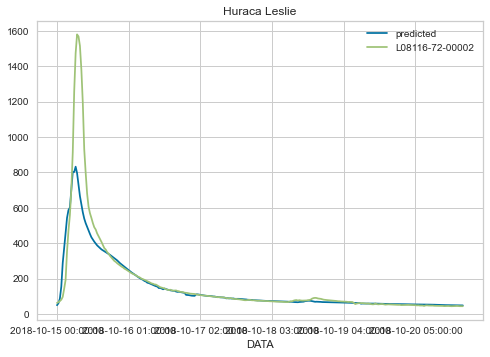

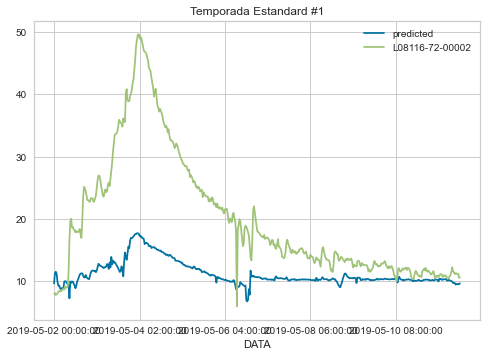

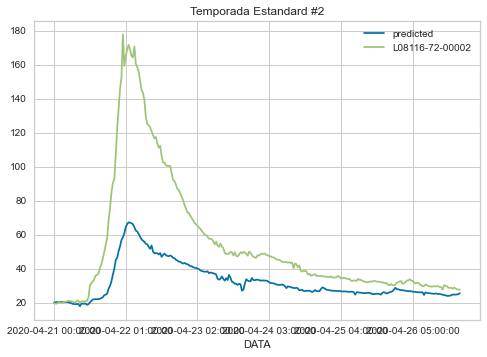

Iteració:  2
CPU times: total: 109 ms
Wall time: 109 ms


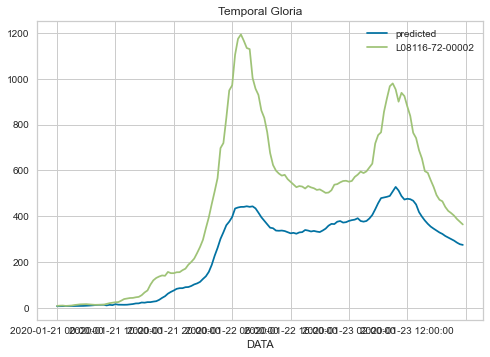

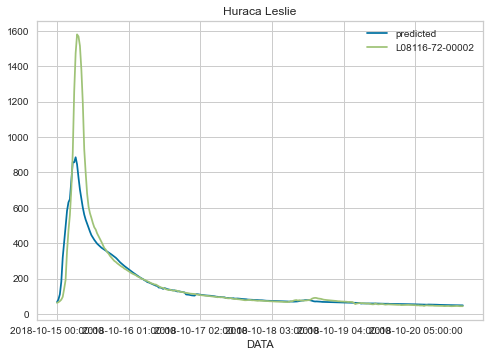

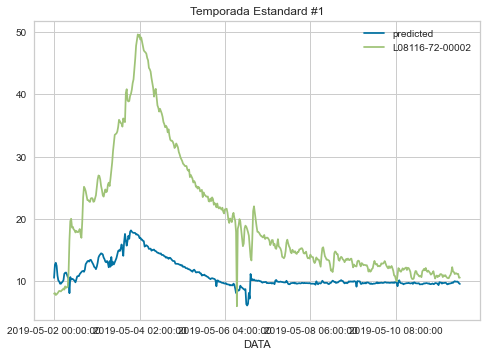

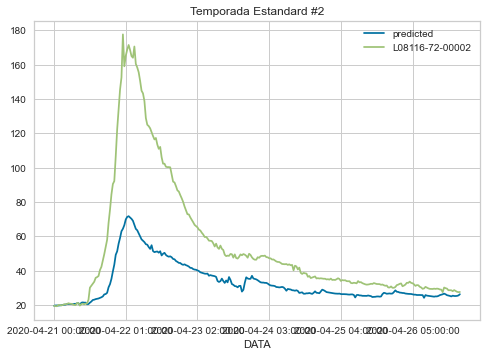

Iteració:  3
CPU times: total: 547 ms
Wall time: 510 ms


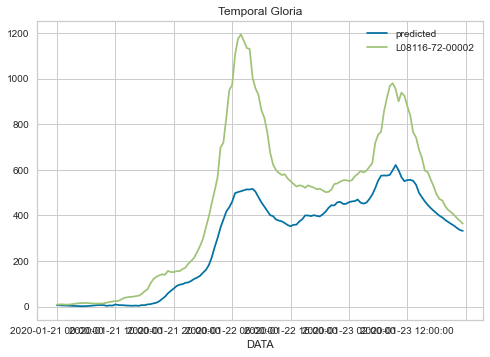

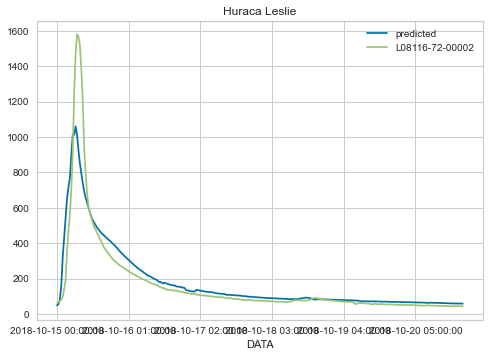

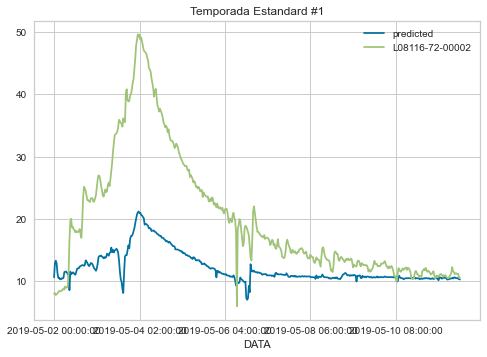

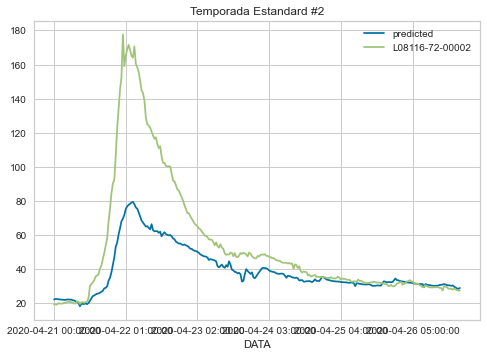

Time:  0:00:02.087009


In [27]:
start = timeit.default_timer()

tscv = TimeSeriesSplit(n_splits=3)
param_search = { 
    'n_estimators': [50,100, 200], # Nombre de arbres
    'max_features': [1, 'sqrt', 'log2'], # Maxim features
    'max_depth' : [8,10,25,None] # Profunditat dels arbres
}

iteracio = 0
for train_index, test_index in tscv.split(Df_AltX):
    iteracio += 1
    Df_AltX_train, Df_AltX_test = Df_AltX.values[train_index], Df_AltX.values[test_index]
    Df_Alty_train, Df_Alty_test = Df_Alty.values.ravel()[train_index], Df_Alty.values.ravel()[test_index]

    model = RANSACRegressor()
    print("Iteració: ", iteracio)
    %time modelfited = model.fit(Df_AltX_train, Df_Alty_train)
        
    score = modelfited.score(Df_AltX_test, Df_Alty_test)
    
    predicty = modelfited.predict(Df_AltX_test)
    rmseScore = mean_squared_error(Df_Alty_test, predicty, squared=False)
    

    hores = "1 day"
    
    
    
    #joblib.dump(modelfited, 'resultsDf/pickle/partAlta/LinearRegression_'+str(df_results_altTer.index[-1])+'.pkl', compress = 1)
    
    plotYtestAnomaly1 = dataPredictionsY["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotYtestAnomaly2 = dataPredictionsY["2018-10-14 5:00:00":"2018-10-20 21:30:00"]
    plotYtestStandard1 = dataPredictionsY["2019-05-01 5:00:00":"2019-05-11 21:30:00"]
    plotYtestStandard2 = dataPredictionsY["2020-04-20 5:00:00":"2020-04-26 21:30:00"]
    
    plotXtestAnomaly1 = dataPredictionsX["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotXtestAnomaly2 = dataPredictionsX["2018-10-14 5:00:00":"2018-10-20 21:30:00"]
    plotXtestStandard1 = dataPredictionsX["2019-05-01 5:00:00":"2019-05-11 21:30:00"]
    plotXtestStandard2 = dataPredictionsX["2020-04-20 5:00:00":"2020-04-26 21:30:00"]
    

    
    predictAnomaly1 = modelfited.predict(plotXtestAnomaly1.values)
    predictAnomaly2 = modelfited.predict(plotXtestAnomaly2.values)
    predictStandard1 = modelfited.predict(plotXtestStandard1.values)
    predictStandard2 = modelfited.predict(plotXtestStandard2.values)
    
    rmseScoreAnomaly1 = mean_squared_error(plotYtestAnomaly1, predictAnomaly1, squared=False)
    rmseScoreAnomaly2 = mean_squared_error(plotYtestAnomaly2, predictAnomaly2, squared=False)
    rmseScoreStandard1 = mean_squared_error(plotYtestStandard1, predictStandard1, squared=False)
    rmseScoreStandard2 = mean_squared_error(plotYtestStandard2, predictStandard2, squared=False)
    
    plotYtestAnomaly1.insert(0, 'predicted', predictAnomaly1, allow_duplicates=True)
    plotYtestAnomaly2.insert(0, 'predicted', predictAnomaly2, allow_duplicates=True)
    plotYtestStandard1.insert(0, 'predicted', predictStandard1, allow_duplicates=True)
    plotYtestStandard2.insert(0, 'predicted', predictStandard2, allow_duplicates=True)
    
    new_row = {'Method':'Linear Regression','RMSE Total':rmseScore, 'Score':score,"Prediccio_Hores":hores,
              'RSME_Gloria':rmseScoreAnomaly1, 'RMSE_Leslie':rmseScoreAnomaly2,'RMSE_Standard1':rmseScoreStandard1,'RMSE_Standard2':rmseScoreStandard2}
    df_results_altTer = df_results_altTer.append(new_row, ignore_index=True)

    plotYtestAnomaly1.plot(title="Temporal Gloria")
    plotYtestAnomaly2.plot(title="Huraca Leslie")
    plotYtestStandard1.plot(title="Temporada Estandard #1")
    plotYtestStandard2.plot(title="Temporada Estandard #2")
    plt.show()

    
stop = timeit.default_timer()
print("Time: ", str(datetime.timedelta(seconds=(stop-start))))

In [28]:
df_results_altTer

Method     Score Prediccio_Hores  RMSE Total  RMSE_Leslie  \
0       Random Forest  0.525588           1 day    8.069291   249.358096   
1       Random Forest   0.78307           1 day    4.538592   221.681936   
2       Random Forest   0.87587           1 day    6.452600   224.125082   
3             XGBoost  0.549761           1 day    7.861023   202.720254   
4             XGBoost  0.815044           1 day    4.190788   194.614060   
5             XGBoost  0.848586           1 day    7.126559   208.573996   
6            LightGBM      None           1 day    7.829297   233.271286   
7            LightGBM      None           1 day    4.717233   242.778436   
8            LightGBM      None           1 day    7.738690   240.351762   
9            CatBoost      None           1 day    8.442543   251.424787   
10           CatBoost      None           1 day    5.009650   244.801402   
11           CatBoost      None           1 day    7.518334   233.592941   
12        Extra Trees  0.660986           1 day    6.821287   226.459644   
13        Extra Trees  0.777723           1 day    4.594186   225.336798   
14        Extra Trees  0.772447           1 day    8.736508   224.598972   
15  Linear Regression  0.597726           1 day    7.430515   121.746740   
16  Linear Regression  0.795968           1 day    4.401598   116.379309   
17  Linear Regression  0.913785           1 day    5.377588    98.816194   

    RMSE_Standard1  RMSE_Standard2  RSME_Gloria  
0         8.276929       28.615760   478.227554  
1         9.178022       23.411833   410.530074  
2         8.698898       21.856674   417.480949  
3         8.485928       26.633486   357.103092  
4        11.738527       22.264948   329.077606  
5         8.849939       28.790826   373.868281  
6         8.629657       27.260631   431.661061  
7        10.712867       25.118754   459.727238  
8        10.302029       30.222978   455.236277  
9        10.696561       30.530444   484.287984  
10       10.190909       25.418154   469.624955  
11       10.908429       24.178872   439.868410  
12        9.216758       27.244394   430.863867  
13        9.799710       31.431949   428.281593  
14        9.864923       29.042980   422.227567  
15       12.086693       34.027909   287.459059  
16       12.060862       32.887783   272.905089  
17       11.063014       28.145772   228.255390

In [29]:
df_results_altTer.drop(columns=['Score','Prediccio_Hores'], inplace=True)
df_results_altTer.to_latex("Resultats/GridSearchManual/AltTer/DfAltTerStandardResults.tex")
df_results_altTer.to_csv("Resultats/GridSearchManual/AltTer/DfAltTerStandardResults.csv")

# Models Baix Ter

# Random Forest (Baix Ter)

In [40]:
df_results_baixTer = pd.DataFrame(columns = ["Method","Score","RMSE_Score","Prediccio_Hores"])

Iteració:  1
CPU times: total: 1.17 s
Wall time: 7.64 s


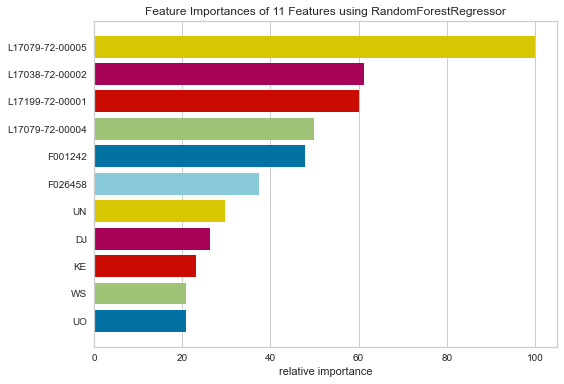

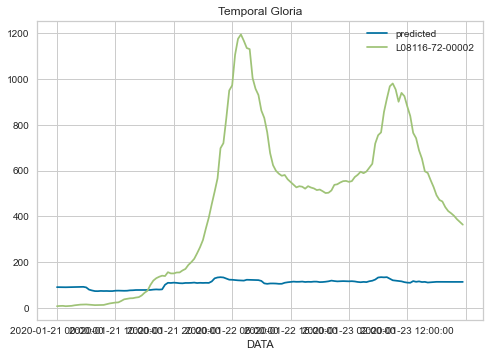

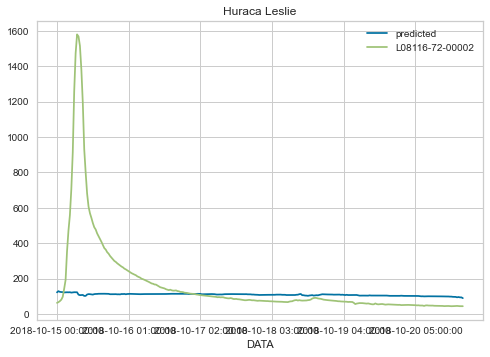

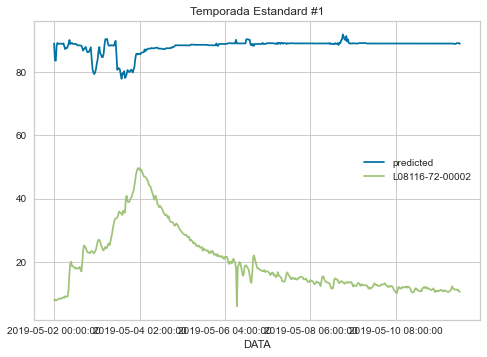

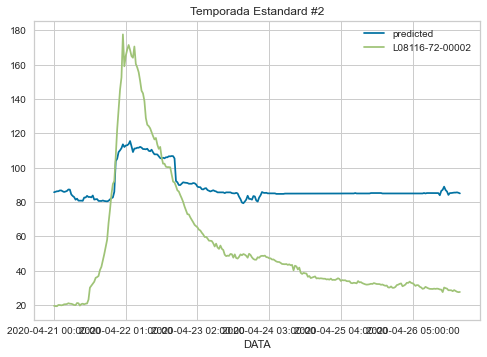

Iteració:  2
CPU times: total: 1.09 s
Wall time: 6.45 s


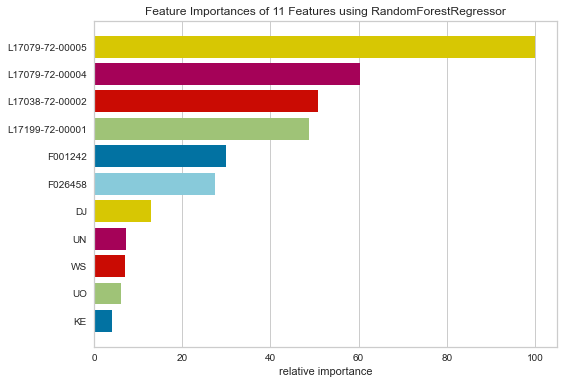

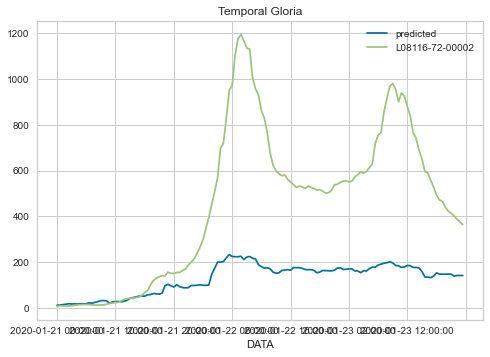

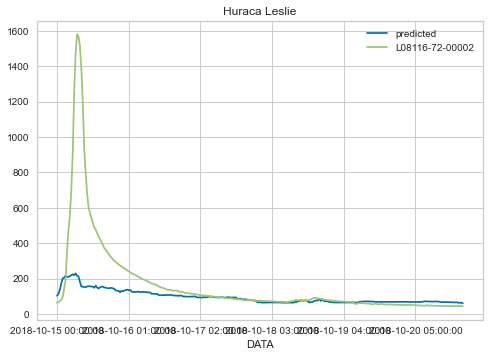

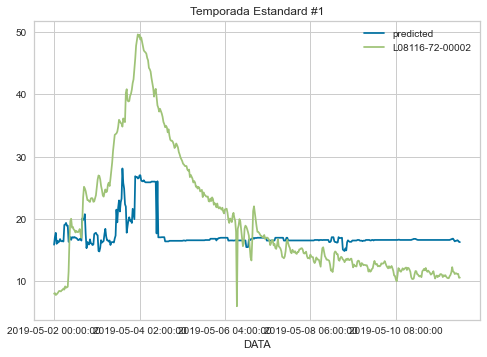

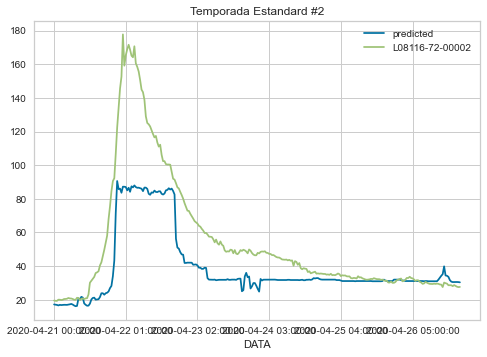

Iteració:  3
CPU times: total: 2.45 s
Wall time: 8.73 s


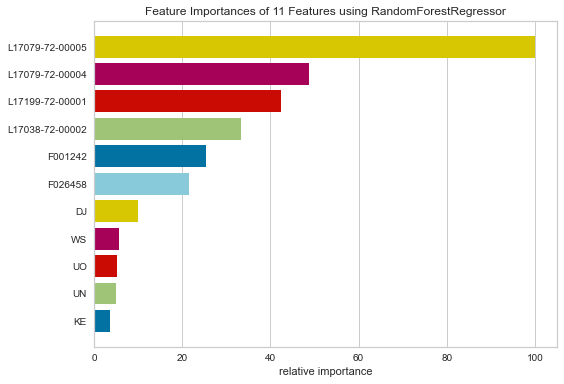

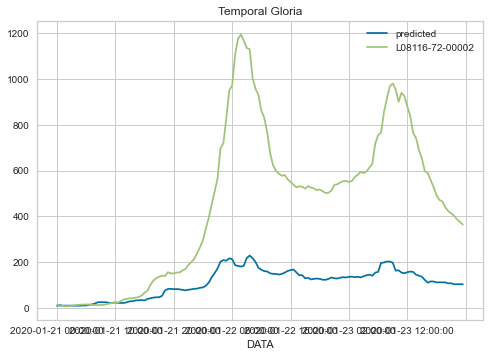

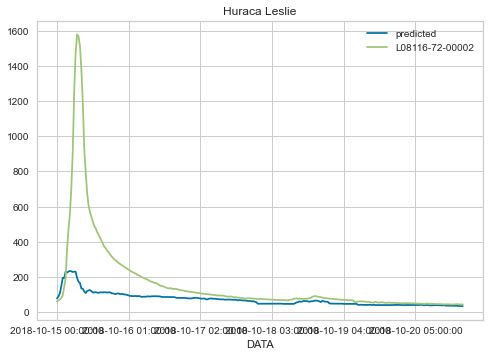

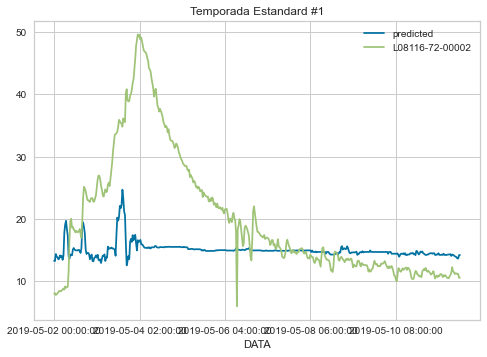

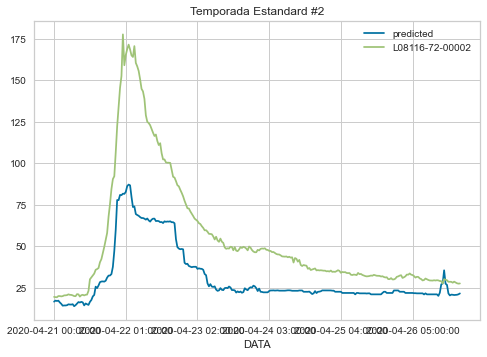

Time:  0:00:25.109343


In [41]:
start = timeit.default_timer()

tscv = TimeSeriesSplit(n_splits=3)
param_search = { 
    'n_estimators': [50,100, 200], # Nombre de arbres
    'max_features': [1, 'sqrt', 'log2'], # Maxim features
    'max_depth' : [8,10,25,None] # Profunditat dels arbres
}

iteracio = 0
for train_index, test_index in tscv.split(Df_BaixX):
    iteracio += 1
    Df_BaixX_train, Df_BaixX_test = Df_BaixX.values[train_index], Df_BaixX.values[test_index]
    Df_Baixy_train, Df_Baixy_test = Df_Baixy.values.ravel()[train_index], Df_Baixy.values.ravel()[test_index]

    model = RandomForestRegressor()
    tscv = TimeSeriesSplit()
    gsearch = HalvingGridSearchCV(estimator=model, cv=tscv, param_grid=param_search, n_jobs=-1)
    print("Iteració: ", iteracio)
    %time gsearchfited = gsearch.fit(Df_BaixX_train, Df_Baixy_train)
        
    bestParams = gsearchfited.best_params_
    score = gsearchfited.score(Df_BaixX_test, Df_Baixy_test)
    FeatureImportance = gsearchfited.best_estimator_.feature_importances_
    
    predicty = gsearchfited.best_estimator_.predict(Df_BaixX_test)
    rmseScore = mean_squared_error(Df_Baixy_test, predicty, squared=False)
    
    nameh = Df_BaixX.columns[0]
    hores = "1 day"

    viz = FeatureImportances(gsearchfited.best_estimator_)
    viz.fit(Df_BaixX, Df_Baixy)
    viz.show()
    
    plotYtestAnomaly1 = dataPredictionsY["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotYtestAnomaly2 = dataPredictionsY["2018-10-14 5:00:00":"2018-10-20 21:30:00"]
    plotYtestStandard1 = dataPredictionsY["2019-05-01 5:00:00":"2019-05-11 21:30:00"]
    plotYtestStandard2 = dataPredictionsY["2020-04-20 5:00:00":"2020-04-26 21:30:00"]
    
    plotXtestAnomaly1 = dataPredictionsX["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotXtestAnomaly2 = dataPredictionsX["2018-10-14 5:00:00":"2018-10-20 21:30:00"]
    plotXtestStandard1 = dataPredictionsX["2019-05-01 5:00:00":"2019-05-11 21:30:00"]
    plotXtestStandard2 = dataPredictionsX["2020-04-20 5:00:00":"2020-04-26 21:30:00"]
    

    
    predictAnomaly1 = gsearchfited.best_estimator_.predict(plotXtestAnomaly1.values)
    predictAnomaly2 = gsearchfited.best_estimator_.predict(plotXtestAnomaly2.values)
    predictStandard1 = gsearchfited.best_estimator_.predict(plotXtestStandard1.values)
    predictStandard2 = gsearchfited.best_estimator_.predict(plotXtestStandard2.values)
    
    rmseScoreAnomaly1 = mean_squared_error(plotYtestAnomaly1, predictAnomaly1, squared=False)
    rmseScoreAnomaly2 = mean_squared_error(plotYtestAnomaly2, predictAnomaly2, squared=False)
    rmseScoreStandard1 = mean_squared_error(plotYtestStandard1, predictStandard1, squared=False)
    rmseScoreStandard2 = mean_squared_error(plotYtestStandard2, predictStandard2, squared=False)
    
    plotYtestAnomaly1.insert(0, 'predicted', predictAnomaly1, allow_duplicates=True)
    plotYtestAnomaly2.insert(0, 'predicted', predictAnomaly2, allow_duplicates=True)
    plotYtestStandard1.insert(0, 'predicted', predictStandard1, allow_duplicates=True)
    plotYtestStandard2.insert(0, 'predicted', predictStandard2, allow_duplicates=True)
    
    new_row = {'Method':'Random Forest','RMSE Total':rmseScore, 'Score':score,"Prediccio_Hores":hores,
              'RSME_Gloria':rmseScoreAnomaly1, 'RMSE_Leslie':rmseScoreAnomaly2,'RMSE_Standard1':rmseScoreStandard1,'RMSE_Standard2':rmseScoreStandard2}
    df_results_baixTer = df_results_baixTer.append(new_row, ignore_index=True)

    plotYtestAnomaly1.plot(title="Temporal Gloria")
    plotYtestAnomaly2.plot(title="Huraca Leslie")
    plotYtestStandard1.plot(title="Temporada Estandard #1")
    plotYtestStandard2.plot(title="Temporada Estandard #2")
    plt.show()

    
stop = timeit.default_timer()
print("Time: ", str(datetime.timedelta(seconds=(stop-start))))

# XGBoost (Baix Ter)

Iteració:  1
[16:21:42] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


CPU times: total: 2.84 s
Wall time: 2.94 s


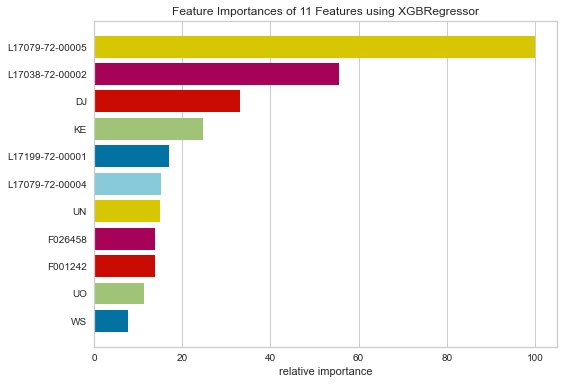

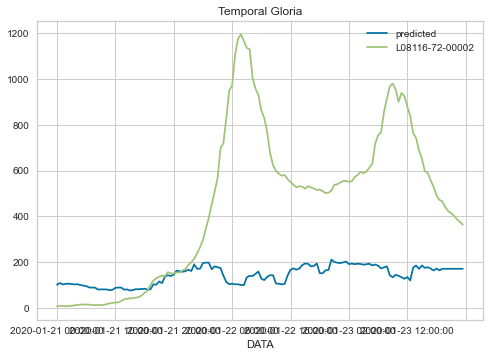

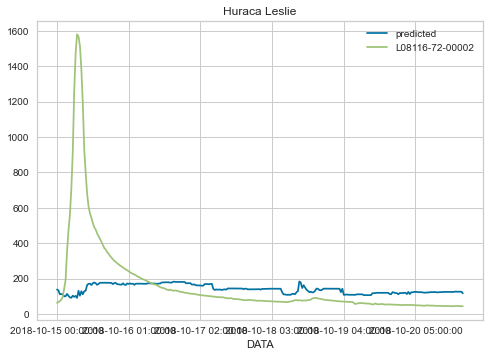

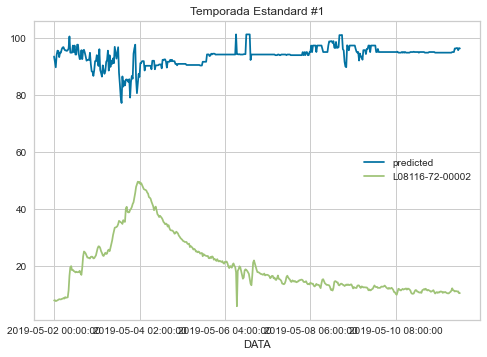

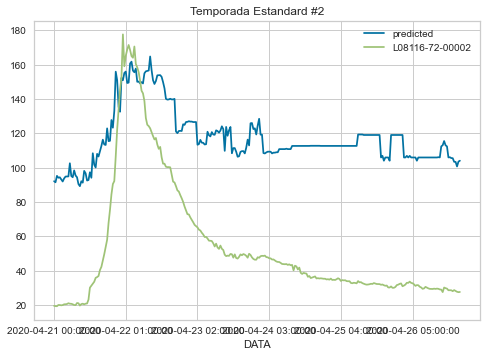

Iteració:  2
[16:21:46] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


CPU times: total: 2.97 s
Wall time: 3.04 s


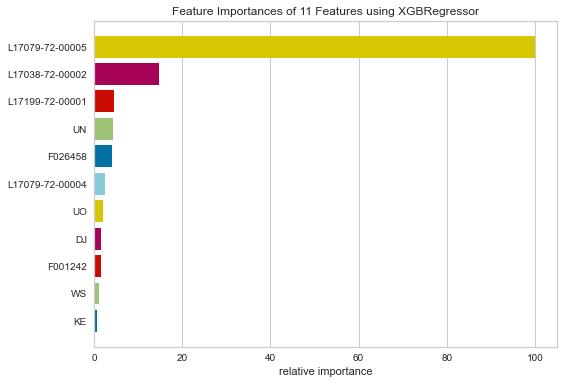

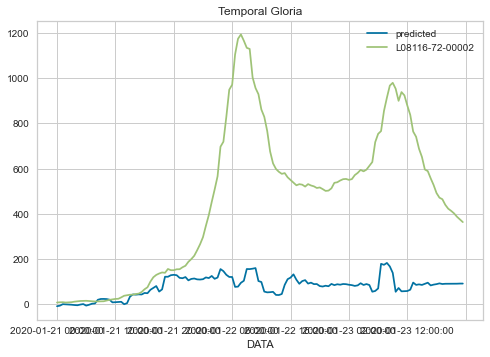

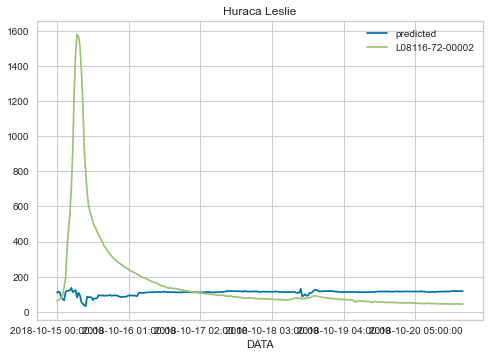

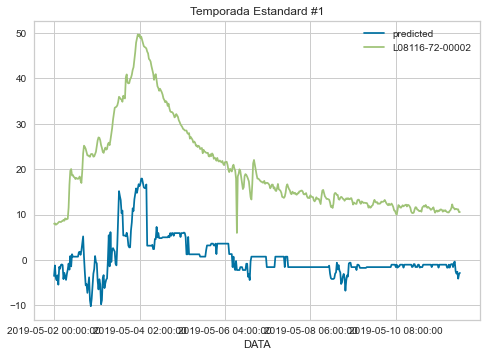

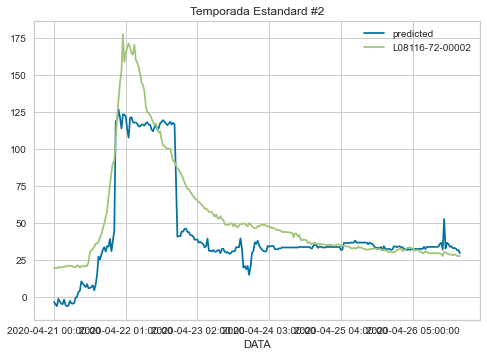

Iteració:  3
[16:21:53] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


CPU times: total: 11.9 s
Wall time: 7.04 s


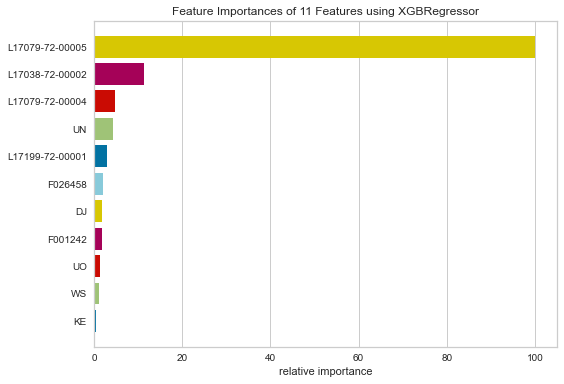

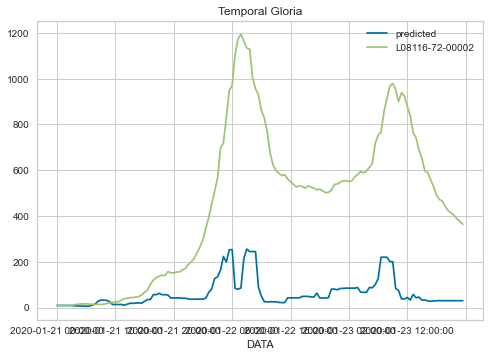

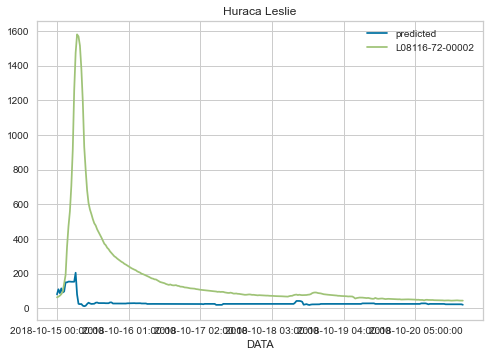

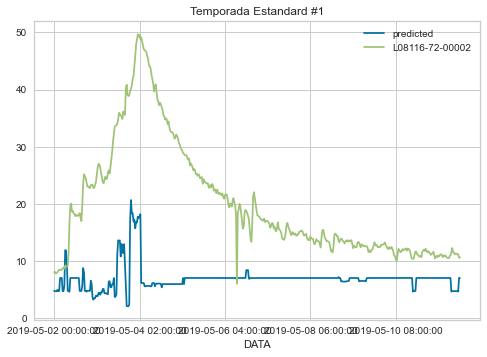

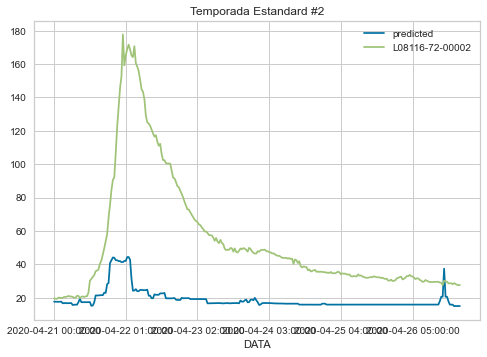

Time:  0:00:14.522065


In [42]:
start = timeit.default_timer()

tscv = TimeSeriesSplit(n_splits=3)
param_search = { 
    'n_estimators': [50,100, 200], # Nombre de arbres
    'max_features': [1, 'sqrt', 'log2'], # Maxim features
    'max_depth' : [8,10,25,None] # Profunditat dels arbres
}

iteracio = 0
for train_index, test_index in tscv.split(Df_BaixX):
    iteracio += 1
    Df_BaixX_train, Df_BaixX_test = Df_BaixX.values[train_index], Df_BaixX.values[test_index]
    Df_Baixy_train, Df_Baixy_test = Df_Baixy.values.ravel()[train_index], Df_Baixy.values.ravel()[test_index]

    model = xgb.XGBRegressor()
    tscv = TimeSeriesSplit()
    gsearch = HalvingGridSearchCV(estimator=model, cv=tscv, param_grid=param_search, n_jobs=-1)
    print("Iteració: ", iteracio)
    %time gsearchfited = gsearch.fit(Df_BaixX_train, Df_Baixy_train)
        
    bestParams = gsearchfited.best_params_
    score = gsearchfited.score(Df_BaixX_test, Df_Baixy_test)
    FeatureImportance = gsearchfited.best_estimator_.feature_importances_
    
    predicty = gsearchfited.best_estimator_.predict(Df_BaixX_test)
    rmseScore = mean_squared_error(Df_Baixy_test, predicty, squared=False)
    
    nameh = Df_BaixX.columns[0]
    hores = "1 day"
    

    viz = FeatureImportances(gsearchfited.best_estimator_)
    viz.fit(Df_BaixX, Df_Baixy)
    viz.show()
    
    plotYtestAnomaly1 = dataPredictionsY["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotYtestAnomaly2 = dataPredictionsY["2018-10-14 5:00:00":"2018-10-20 21:30:00"]
    plotYtestStandard1 = dataPredictionsY["2019-05-01 5:00:00":"2019-05-11 21:30:00"]
    plotYtestStandard2 = dataPredictionsY["2020-04-20 5:00:00":"2020-04-26 21:30:00"]
    
    plotXtestAnomaly1 = dataPredictionsX["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotXtestAnomaly2 = dataPredictionsX["2018-10-14 5:00:00":"2018-10-20 21:30:00"]
    plotXtestStandard1 = dataPredictionsX["2019-05-01 5:00:00":"2019-05-11 21:30:00"]
    plotXtestStandard2 = dataPredictionsX["2020-04-20 5:00:00":"2020-04-26 21:30:00"]
    

    
    predictAnomaly1 = gsearchfited.best_estimator_.predict(plotXtestAnomaly1.values)
    predictAnomaly2 = gsearchfited.best_estimator_.predict(plotXtestAnomaly2.values)
    predictStandard1 = gsearchfited.best_estimator_.predict(plotXtestStandard1.values)
    predictStandard2 = gsearchfited.best_estimator_.predict(plotXtestStandard2.values)
    
    rmseScoreAnomaly1 = mean_squared_error(plotYtestAnomaly1, predictAnomaly1, squared=False)
    rmseScoreAnomaly2 = mean_squared_error(plotYtestAnomaly2, predictAnomaly2, squared=False)
    rmseScoreStandard1 = mean_squared_error(plotYtestStandard1, predictStandard1, squared=False)
    rmseScoreStandard2 = mean_squared_error(plotYtestStandard2, predictStandard2, squared=False)
    
    plotYtestAnomaly1.insert(0, 'predicted', predictAnomaly1, allow_duplicates=True)
    plotYtestAnomaly2.insert(0, 'predicted', predictAnomaly2, allow_duplicates=True)
    plotYtestStandard1.insert(0, 'predicted', predictStandard1, allow_duplicates=True)
    plotYtestStandard2.insert(0, 'predicted', predictStandard2, allow_duplicates=True)
    
    new_row = {'Method':'XGBoost','RMSE Total':rmseScore,'Score':score,"Prediccio_Hores":hores,
              'RSME_Gloria':rmseScoreAnomaly1, 'RMSE_Leslie':rmseScoreAnomaly2,'RMSE_Standard1':rmseScoreStandard1,'RMSE_Standard2':rmseScoreStandard2}
    df_results_baixTer = df_results_baixTer.append(new_row, ignore_index=True)

    plotYtestAnomaly1.plot(title="Temporal Gloria")
    plotYtestAnomaly2.plot(title="Huraca Leslie")
    plotYtestStandard1.plot(title="Temporada Estandard #1")
    plotYtestStandard2.plot(title="Temporada Estandard #2")
    plt.show()


    
stop = timeit.default_timer()
print("Time: ", str(datetime.timedelta(seconds=(stop-start))))

## LightGBM (Baix Ter)

1861


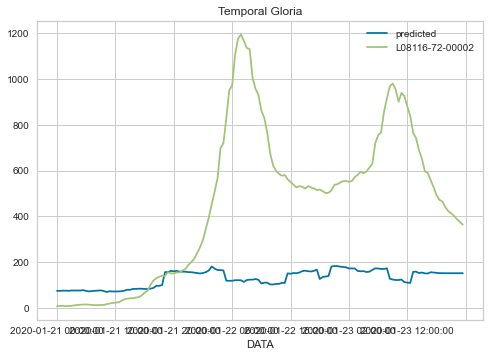

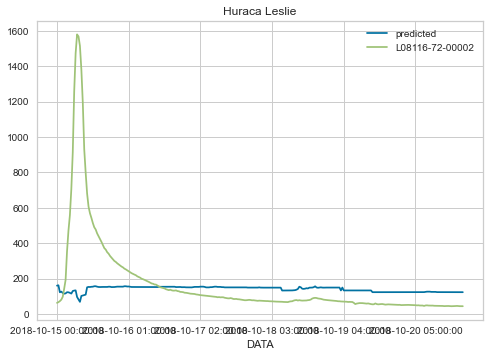

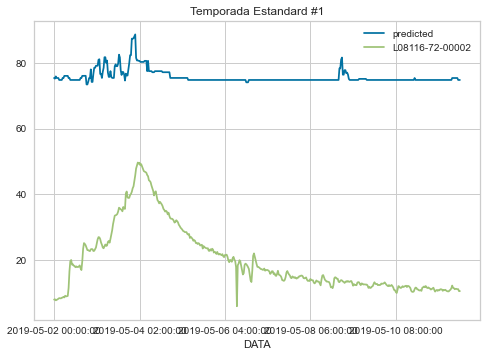

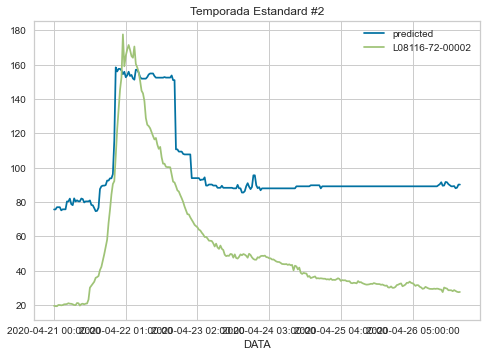

3721


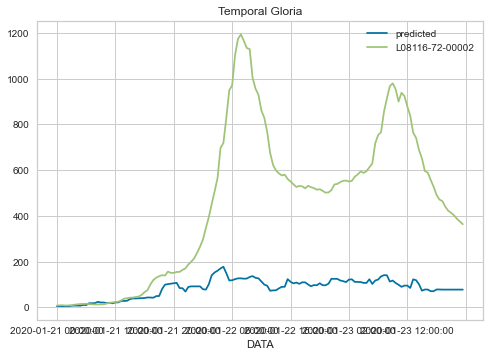

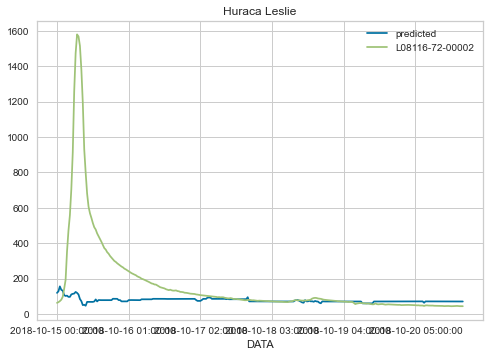

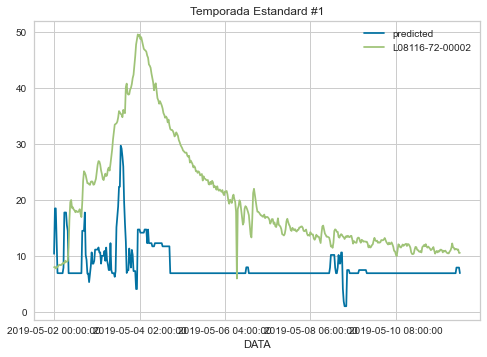

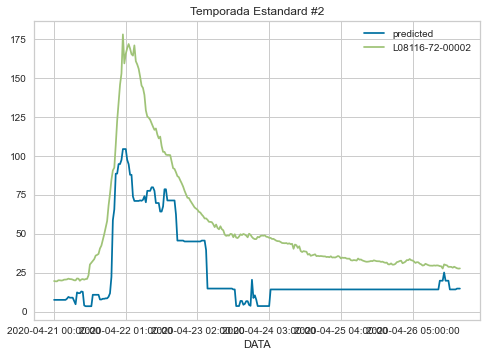

5581


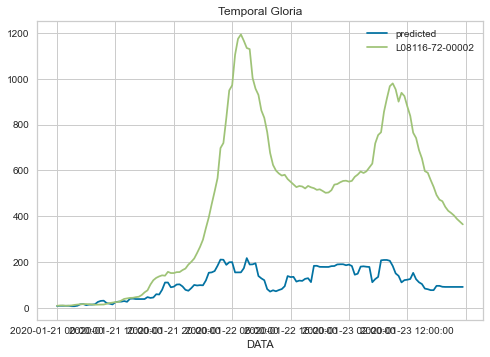

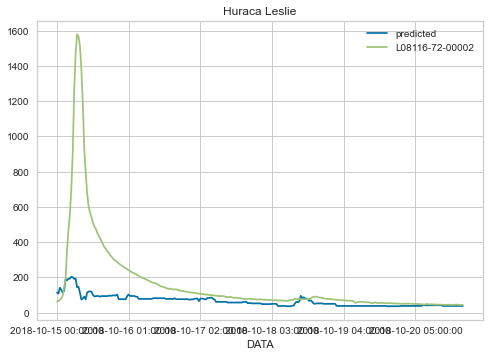

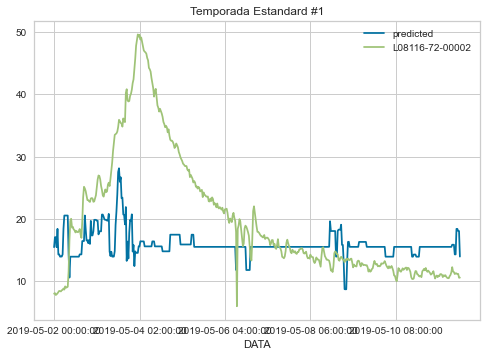

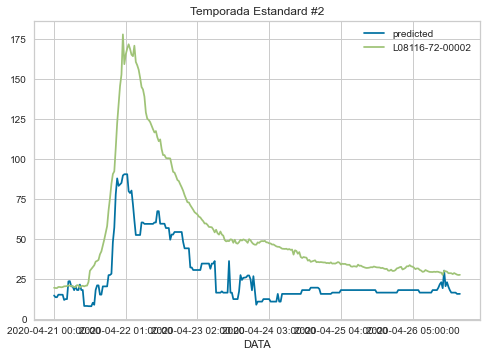

Time:  0:00:01.379545


In [43]:
start = timeit.default_timer()

tscv = TimeSeriesSplit(n_splits=3)
param_search = {
                        "objective": "regression",
                        "metric": "rmse",
                        "verbosity": -1,
                        "boosting_type": "gbdt",
                        "seed": 42,
                        'linear_tree': False,
                        'learning_rate': .15,
                        'min_child_samples': 5,
                        'num_leaves': 31,
                        'num_iterations': 50
                    }

#Calcular només amb els valors on plou


iteracio = 0
for train_index, test_index in tscv.split(Df_BaixX):
    iteracio += 1
    Df_BaixX_train, Df_BaixX_test = Df_BaixX.values[train_index], Df_BaixX.values[test_index]
    Df_Baixy_train, Df_Baixy_test = Df_Baixy.values.ravel()[train_index], Df_Baixy.values.ravel()[test_index]
    
    print(Df_BaixX.iloc[test_index].index[0])

    model = lgb.LGBMRegressor(first_metric_only = True, **param_search)
    
    model.fit(Df_BaixX_train, Df_Baixy_train,
          eval_metric = 'l1', 
          eval_set = [(Df_BaixX_test, Df_Baixy_test)],
          #early_stopping_rounds = 10,
          verbose = 0)
    predicty = model.predict(Df_BaixX_test)
    rmseScore = mean_squared_error(Df_Baixy_test, predicty, squared=False)
    
    nameh = Df_BaixX.columns[0]
    hores = "1 day"
    
    
    
    #joblib.dump(gsearchfited.best_estimator_, 'resultsDf/pickle/partBaixa/XGBoost_'+str(df_results_BaixTer.index[-1])+'.pkl', compress = 1)

    #viz = FeatureImportances(gsearchfited.best_estimator_)
    #viz.fit(Df_BaixX, Df_Baixy)
    #viz.show()
    
    plotYtestAnomaly1 = dataPredictionsY["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotYtestAnomaly2 = dataPredictionsY["2018-10-14 5:00:00":"2018-10-20 21:30:00"]
    plotYtestStandard1 = dataPredictionsY["2019-05-01 5:00:00":"2019-05-11 21:30:00"]
    plotYtestStandard2 = dataPredictionsY["2020-04-20 5:00:00":"2020-04-26 21:30:00"]
    
    plotXtestAnomaly1 = dataPredictionsX["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotXtestAnomaly2 = dataPredictionsX["2018-10-14 5:00:00":"2018-10-20 21:30:00"]
    plotXtestStandard1 = dataPredictionsX["2019-05-01 5:00:00":"2019-05-11 21:30:00"]
    plotXtestStandard2 = dataPredictionsX["2020-04-20 5:00:00":"2020-04-26 21:30:00"]
    

    
    predictAnomaly1 = model.predict(plotXtestAnomaly1.values)
    predictAnomaly2 = model.predict(plotXtestAnomaly2.values)
    predictStandard1 = model.predict(plotXtestStandard1.values)
    predictStandard2 = model.predict(plotXtestStandard2.values)
    
    rmseScoreAnomaly1 = mean_squared_error(plotYtestAnomaly1, predictAnomaly1, squared=False)
    rmseScoreAnomaly2 = mean_squared_error(plotYtestAnomaly2, predictAnomaly2, squared=False)
    rmseScoreStandard1 = mean_squared_error(plotYtestStandard1, predictStandard1, squared=False)
    rmseScoreStandard2 = mean_squared_error(plotYtestStandard2, predictStandard2, squared=False)
    
    plotYtestAnomaly1.insert(0, 'predicted', predictAnomaly1, allow_duplicates=True)
    plotYtestAnomaly2.insert(0, 'predicted', predictAnomaly2, allow_duplicates=True)
    plotYtestStandard1.insert(0, 'predicted', predictStandard1, allow_duplicates=True)
    plotYtestStandard2.insert(0, 'predicted', predictStandard2, allow_duplicates=True)
    
    new_row = {'Method':'LightGBM','RMSE Total':rmseScore,"Prediccio_Hores":hores,
              'RSME_Gloria':rmseScoreAnomaly1, 'RMSE_Leslie':rmseScoreAnomaly2,'RMSE_Standard1':rmseScoreStandard1,'RMSE_Standard2':rmseScoreStandard2}
    df_results_baixTer = df_results_baixTer.append(new_row, ignore_index=True)

    plotYtestAnomaly1.plot(title="Temporal Gloria")
    plotYtestAnomaly2.plot(title="Huraca Leslie")
    plotYtestStandard1.plot(title="Temporada Estandard #1")
    plotYtestStandard2.plot(title="Temporada Estandard #2")
    plt.show()

    
stop = timeit.default_timer()
print("Time: ", str(datetime.timedelta(seconds=(stop-start))))

# CatBoost (Baix Ter)

1861


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

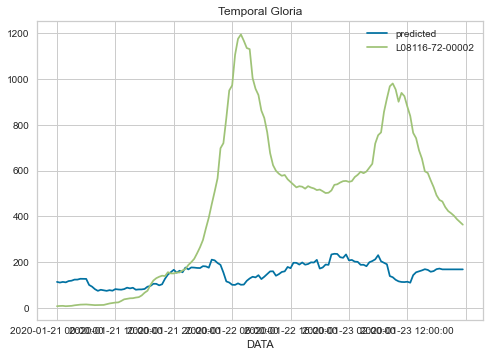

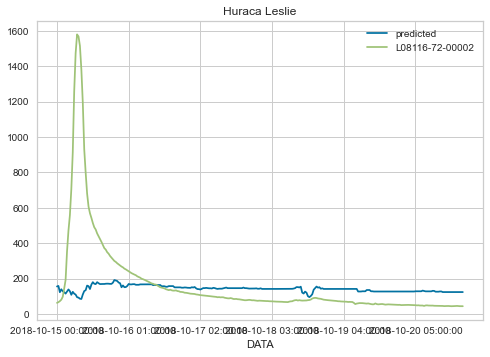

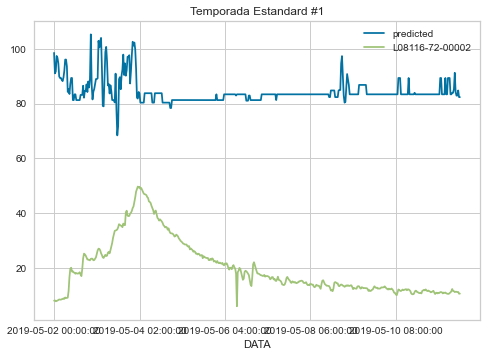

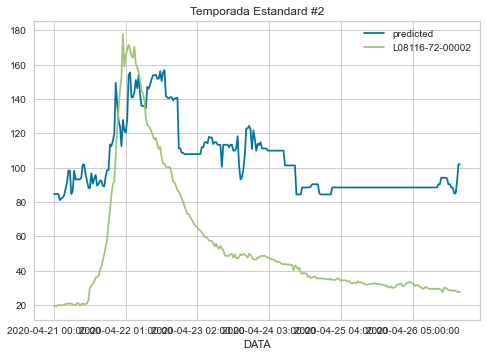

3721


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

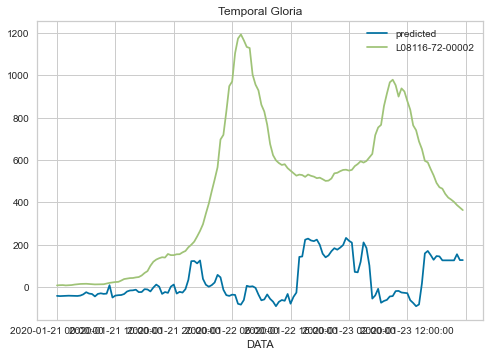

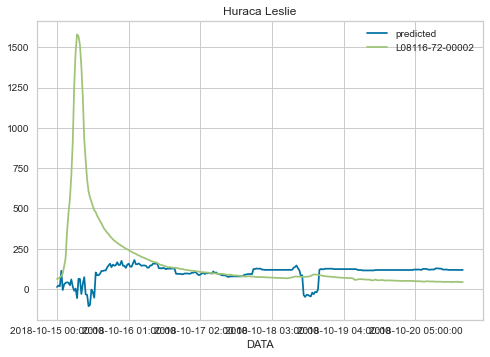

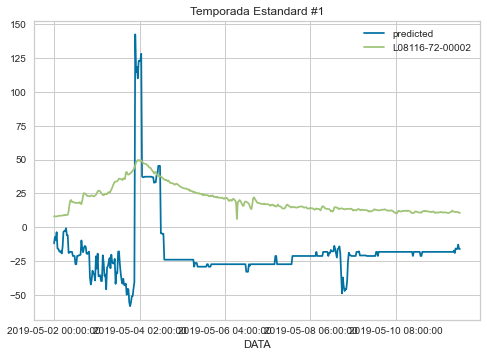

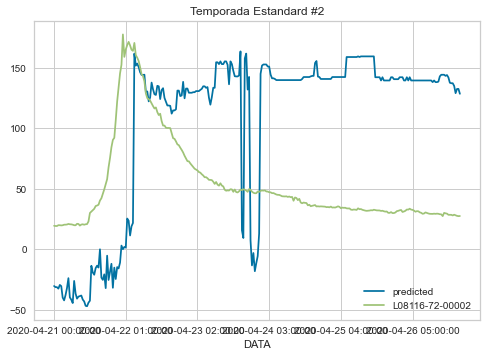

5581


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

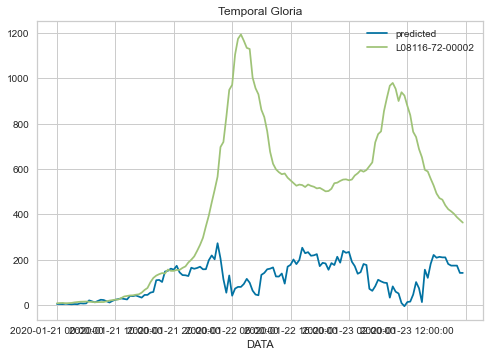

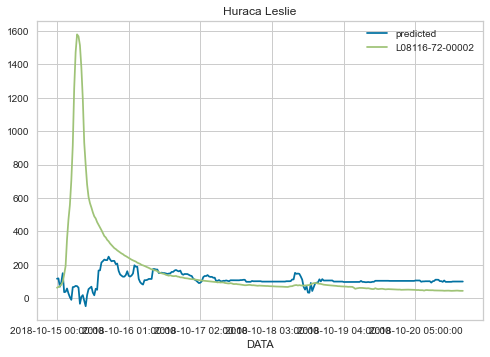

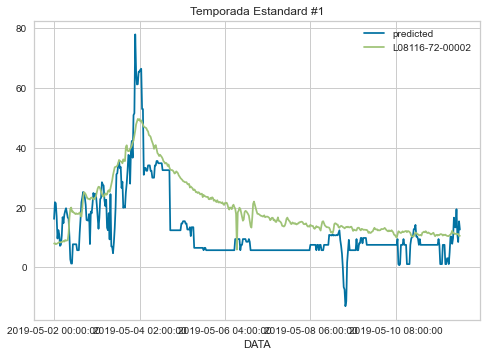

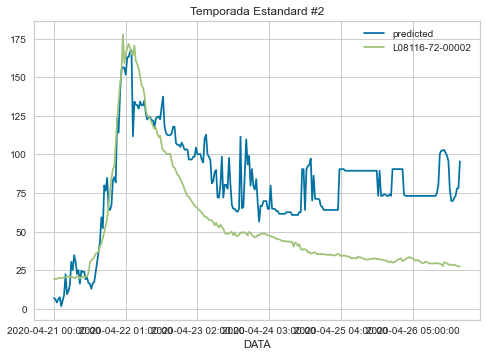

Time:  0:00:02.755892


In [44]:
start = timeit.default_timer()

tscv = TimeSeriesSplit(n_splits=3)
param_search = {
    'n_estimators': 2000,
    'max_depth': 4,
    'num_leaves': 2**4,
    'learning_rate': 0.1,
    'boosting_type': 'dart'
}


iteracio = 0
for train_index, test_index in tscv.split(Df_BaixX):
    iteracio += 1
    Df_BaixX_train, Df_BaixX_test = Df_BaixX.values[train_index], Df_BaixX.values[test_index]
    Df_Baixy_train, Df_Baixy_test = Df_Baixy.values.ravel()[train_index], Df_Baixy.values.ravel()[test_index]
    
    print(Df_BaixX.iloc[test_index].index[0])

    model = CatBoostRegressor(loss_function='RMSE', depth=3, learning_rate=0.4, iterations=1000, 
    random_seed=18, 
    od_type='Iter',
    od_wait=20)
    
    model.fit(Df_BaixX_train, Df_Baixy_train,
          use_best_model=True, 
          eval_set = (Df_BaixX_test, Df_Baixy_test),
          #early_stopping_rounds = 10,
          verbose = 0,
        plot=True)
    predicty = model.predict(Df_BaixX_test)
    rmseScore = mean_squared_error(Df_Baixy_test, predicty, squared=False)
    
    nameh = Df_BaixX.columns[0]
    hores = "1 day"
    
    
    
    #joblib.dump(gsearchfited.best_estimator_, 'resultsDf/pickle/partBaixa/XGBoost_'+str(df_results_BaixTer.index[-1])+'.pkl', compress = 1)

    #viz = FeatureImportances(gsearchfited.best_estimator_)
    #viz.fit(Df_BaixX, Df_Baixy)
    #viz.show()
    
    plotYtestAnomaly1 = dataPredictionsY["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotYtestAnomaly2 = dataPredictionsY["2018-10-14 5:00:00":"2018-10-20 21:30:00"]
    plotYtestStandard1 = dataPredictionsY["2019-05-01 5:00:00":"2019-05-11 21:30:00"]
    plotYtestStandard2 = dataPredictionsY["2020-04-20 5:00:00":"2020-04-26 21:30:00"]
    
    plotXtestAnomaly1 = dataPredictionsX["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotXtestAnomaly2 = dataPredictionsX["2018-10-14 5:00:00":"2018-10-20 21:30:00"]
    plotXtestStandard1 = dataPredictionsX["2019-05-01 5:00:00":"2019-05-11 21:30:00"]
    plotXtestStandard2 = dataPredictionsX["2020-04-20 5:00:00":"2020-04-26 21:30:00"]
    

    
    predictAnomaly1 = model.predict(plotXtestAnomaly1.values)
    predictAnomaly2 = model.predict(plotXtestAnomaly2.values)
    predictStandard1 = model.predict(plotXtestStandard1.values)
    predictStandard2 = model.predict(plotXtestStandard2.values)
    
    rmseScoreAnomaly1 = mean_squared_error(plotYtestAnomaly1, predictAnomaly1, squared=False)
    rmseScoreAnomaly2 = mean_squared_error(plotYtestAnomaly2, predictAnomaly2, squared=False)
    rmseScoreStandard1 = mean_squared_error(plotYtestStandard1, predictStandard1, squared=False)
    rmseScoreStandard2 = mean_squared_error(plotYtestStandard2, predictStandard2, squared=False)
    
    plotYtestAnomaly1.insert(0, 'predicted', predictAnomaly1, allow_duplicates=True)
    plotYtestAnomaly2.insert(0, 'predicted', predictAnomaly2, allow_duplicates=True)
    plotYtestStandard1.insert(0, 'predicted', predictStandard1, allow_duplicates=True)
    plotYtestStandard2.insert(0, 'predicted', predictStandard2, allow_duplicates=True)
    
    new_row = {'Method':'CatBoost','RMSE Total':rmseScore,'Score':None,"Prediccio_Hores":hores,
              'RSME_Gloria':rmseScoreAnomaly1, 'RMSE_Leslie':rmseScoreAnomaly2,'RMSE_Standard1':rmseScoreStandard1,'RMSE_Standard2':rmseScoreStandard2}
    df_results_BaixTer = df_results_baixTer.append(new_row, ignore_index=True)

    plotYtestAnomaly1.plot(title="Temporal Gloria")
    plotYtestAnomaly2.plot(title="Huraca Leslie")
    plotYtestStandard1.plot(title="Temporada Estandard #1")
    plotYtestStandard2.plot(title="Temporada Estandard #2")
    plt.show()

    
stop = timeit.default_timer()
print("Time: ", str(datetime.timedelta(seconds=(stop-start))))

# ExtraTrees (Baix Ter)

Iteració:  1
CPU times: total: 656 ms
Wall time: 3.73 s


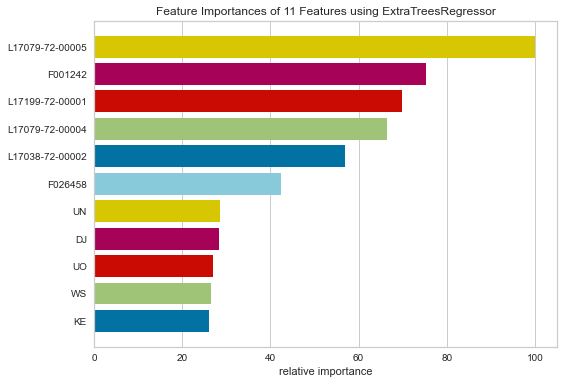

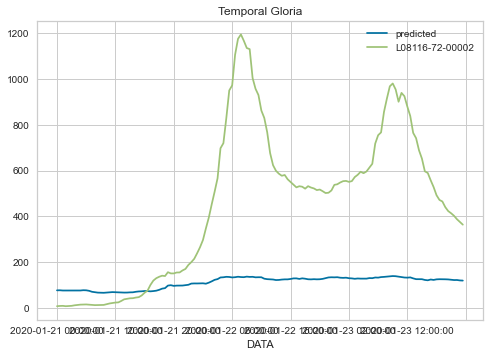

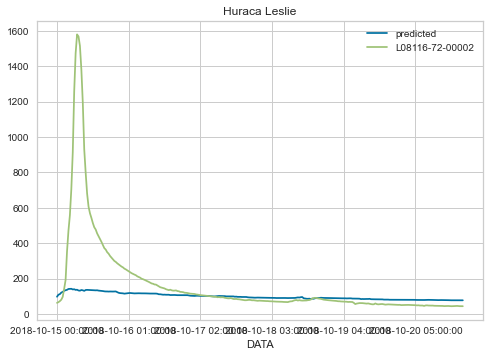

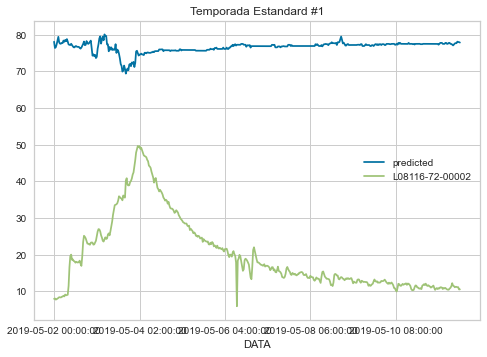

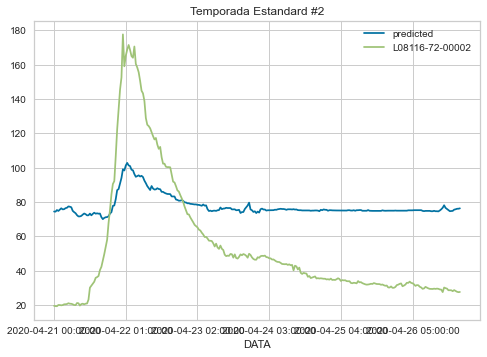

Iteració:  2
CPU times: total: 547 ms
Wall time: 3.78 s


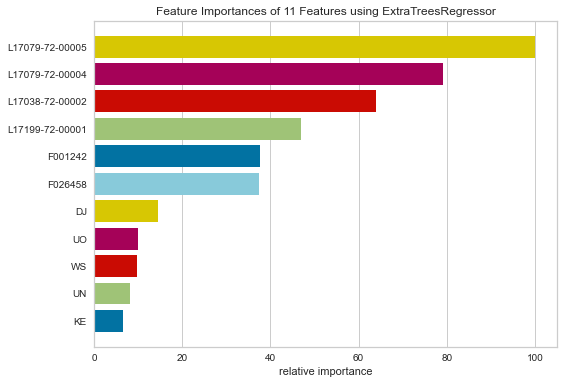

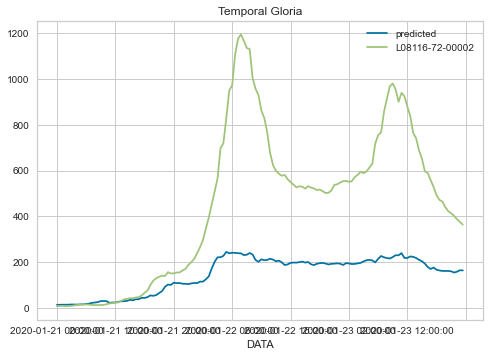

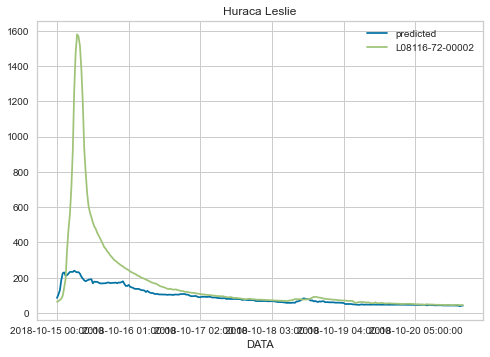

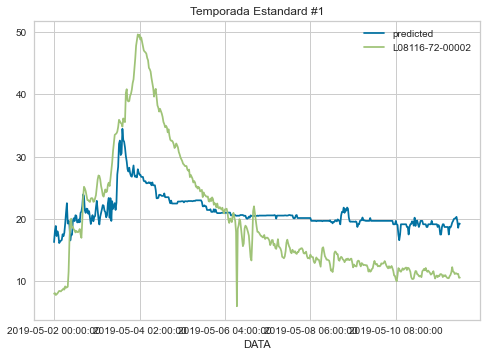

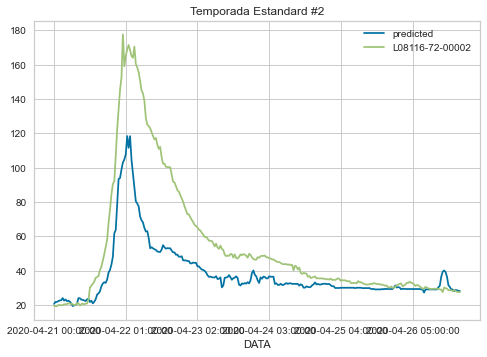

Iteració:  3
CPU times: total: 875 ms
Wall time: 5.26 s


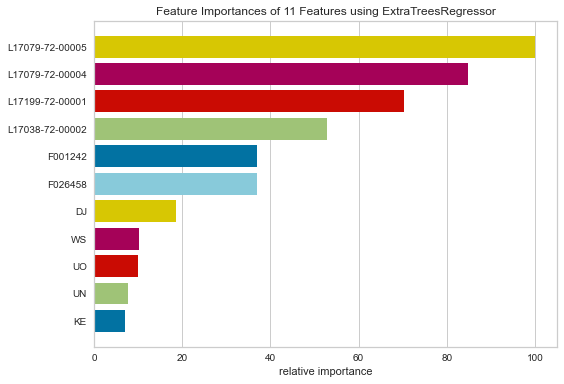

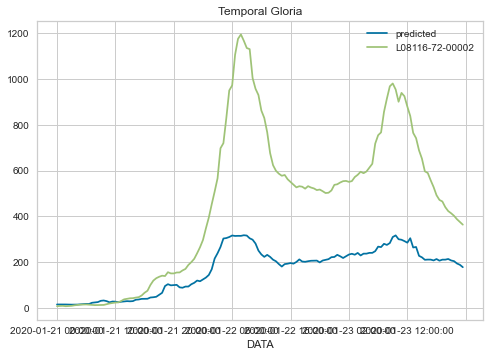

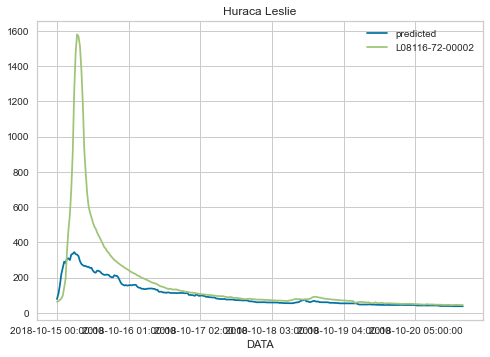

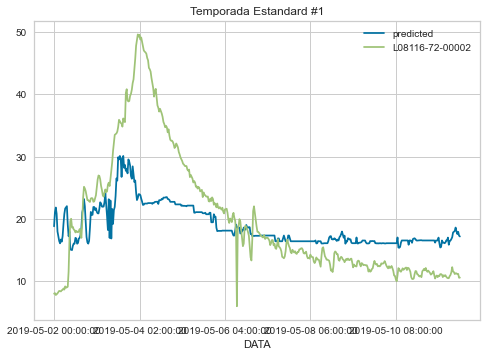

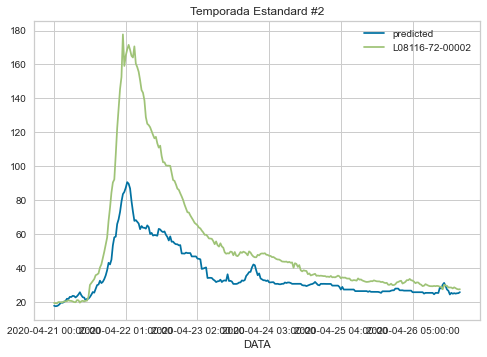

Time:  0:00:14.583928


In [45]:
start = timeit.default_timer()

tscv = TimeSeriesSplit(n_splits=3)
param_search = { 
    'n_estimators': [50,100, 200], # Nombre de arbres
    'max_features': [1, 'sqrt', 'log2'], # Maxim features
    'max_depth' : [8,10,25,None] # Profunditat dels arbres
}

iteracio = 0
for train_index, test_index in tscv.split(Df_BaixX):
    iteracio += 1
    Df_BaixX_train, Df_BaixX_test = Df_BaixX.values[train_index], Df_BaixX.values[test_index]
    Df_Baixy_train, Df_Baixy_test = Df_Baixy.values.ravel()[train_index], Df_Baixy.values.ravel()[test_index]

    model = ExtraTreesRegressor()
    tscv = TimeSeriesSplit()
    gsearch = HalvingGridSearchCV(estimator=model, cv=tscv, param_grid=param_search, n_jobs=-1)
    print("Iteració: ", iteracio)
    %time gsearchfited = gsearch.fit(Df_BaixX_train, Df_Baixy_train)
        
    bestParams = gsearchfited.best_params_
    score = gsearchfited.score(Df_BaixX_test, Df_Baixy_test)
    FeatureImportance = gsearchfited.best_estimator_.feature_importances_
    
    predicty = gsearchfited.best_estimator_.predict(Df_BaixX_test)
    rmseScore = mean_squared_error(Df_Baixy_test, predicty, squared=False)
    
    nameh = Df_BaixX.columns[0]
    hores = "1 day"
    
    viz = FeatureImportances(gsearchfited.best_estimator_)
    viz.fit(Df_BaixX, Df_Baixy)
    viz.show()
    
    plotYtestAnomaly1 = dataPredictionsY["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotYtestAnomaly2 = dataPredictionsY["2018-10-14 5:00:00":"2018-10-20 21:30:00"]
    plotYtestStandard1 = dataPredictionsY["2019-05-01 5:00:00":"2019-05-11 21:30:00"]
    plotYtestStandard2 = dataPredictionsY["2020-04-20 5:00:00":"2020-04-26 21:30:00"]
    
    plotXtestAnomaly1 = dataPredictionsX["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotXtestAnomaly2 = dataPredictionsX["2018-10-14 5:00:00":"2018-10-20 21:30:00"]
    plotXtestStandard1 = dataPredictionsX["2019-05-01 5:00:00":"2019-05-11 21:30:00"]
    plotXtestStandard2 = dataPredictionsX["2020-04-20 5:00:00":"2020-04-26 21:30:00"]
    

    
    predictAnomaly1 = gsearchfited.best_estimator_.predict(plotXtestAnomaly1.values)
    predictAnomaly2 = gsearchfited.best_estimator_.predict(plotXtestAnomaly2.values)
    predictStandard1 = gsearchfited.best_estimator_.predict(plotXtestStandard1.values)
    predictStandard2 = gsearchfited.best_estimator_.predict(plotXtestStandard2.values)
    
    rmseScoreAnomaly1 = mean_squared_error(plotYtestAnomaly1, predictAnomaly1, squared=False)
    rmseScoreAnomaly2 = mean_squared_error(plotYtestAnomaly2, predictAnomaly2, squared=False)
    rmseScoreStandard1 = mean_squared_error(plotYtestStandard1, predictStandard1, squared=False)
    rmseScoreStandard2 = mean_squared_error(plotYtestStandard2, predictStandard2, squared=False)
    
    plotYtestAnomaly1.insert(0, 'predicted', predictAnomaly1, allow_duplicates=True)
    plotYtestAnomaly2.insert(0, 'predicted', predictAnomaly2, allow_duplicates=True)
    plotYtestStandard1.insert(0, 'predicted', predictStandard1, allow_duplicates=True)
    plotYtestStandard2.insert(0, 'predicted', predictStandard2, allow_duplicates=True)
    
    new_row = {'Method':'ExtraTrees','RMSE Total':rmseScore,'Score':score,"Prediccio_Hores":hores,
              'RSME_Gloria':rmseScoreAnomaly1, 'RMSE_Leslie':rmseScoreAnomaly2,'RMSE_Standard1':rmseScoreStandard1,'RMSE_Standard2':rmseScoreStandard2}
    df_results_baixTer = df_results_baixTer.append(new_row, ignore_index=True)

    plotYtestAnomaly1.plot(title="Temporal Gloria")
    plotYtestAnomaly2.plot(title="Huraca Leslie")
    plotYtestStandard1.plot(title="Temporada Estandard #1")
    plotYtestStandard2.plot(title="Temporada Estandard #2")
    plt.show()


    
stop = timeit.default_timer()
print("Time: ", str(datetime.timedelta(seconds=(stop-start))))

# Linear Regression (Baix Ter)

In [46]:
start = timeit.default_timer()

tscv = TimeSeriesSplit(n_splits=3)
param_search = { 
    'n_estimators': [50,100, 200], # Nombre de arbres
    'max_features': [1, 'sqrt', 'log2'], # Maxim features
    'max_depth' : [8,10,25,None] # Profunditat dels arbres
}

iteracio = 0
for train_index, test_index in tscv.split(Df_BaixX):
    iteracio += 1
    Df_BaixX_train, Df_BaixX_test = Df_BaixX.iloc[train_index, :], Df_BaixX.iloc[test_index, :]
    Df_Baixy_train, Df_Baixy_test = Df_Baixy.iloc[train_index], Df_Baixy.iloc[test_index]

    model = LinearRegression()
    print("Iteració: ", iteracio)
    %time modelfited = model.fit(Df_BaixX_train, Df_Baixy_train)
        
    score = modelfited.score(Df_BaixX_test, Df_Baixy_test)
    
    predicty = modelfited.predict(Df_BaixX_test)
    rmseScore = mean_squared_error(Df_Baixy_test, predicty, squared=False)
    

    hores = "1 day"
    
    plotYtestAnomaly1 = dataPredictionsY["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotYtestAnomaly2 = dataPredictionsY["2018-10-14 5:00:00":"2018-10-20 21:30:00"]
    plotYtestStandard1 = dataPredictionsY["2019-05-01 5:00:00":"2019-05-11 21:30:00"]
    plotYtestStandard2 = dataPredictionsY["2020-04-20 5:00:00":"2020-04-26 21:30:00"]
    
    plotXtestAnomaly1 = dataPredictionsX["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotXtestAnomaly2 = dataPredictionsX["2018-10-14 5:00:00":"2018-10-20 21:30:00"]
    plotXtestStandard1 = dataPredictionsX["2019-05-01 5:00:00":"2019-05-11 21:30:00"]
    plotXtestStandard2 = dataPredictionsX["2020-04-20 5:00:00":"2020-04-26 21:30:00"]
    

    
    predictAnomaly1 = modelfited.predict(plotXtestAnomaly1.values)
    predictAnomaly2 = modelfited.predict(plotXtestAnomaly2.values)
    predictStandard1 = modelfited.predict(plotXtestStandard1.values)
    predictStandard2 = modelfited.predict(plotXtestStandard2.values)
    
    rmseScoreAnomaly1 = mean_squared_error(plotYtestAnomaly1, predictAnomaly1, squared=False)
    rmseScoreAnomaly2 = mean_squared_error(plotYtestAnomaly2, predictAnomaly2, squared=False)
    rmseScoreStandard1 = mean_squared_error(plotYtestStandard1, predictStandard1, squared=False)
    rmseScoreStandard2 = mean_squared_error(plotYtestStandard2, predictStandard2, squared=False)
    
    plotYtestAnomaly1.insert(0, 'predicted', predictAnomaly1, allow_duplicates=True)
    plotYtestAnomaly2.insert(0, 'predicted', predictAnomaly2, allow_duplicates=True)
    plotYtestStandard1.insert(0, 'predicted', predictStandard1, allow_duplicates=True)
    plotYtestStandard2.insert(0, 'predicted', predictStandard2, allow_duplicates=True)
    
    new_row = {'Method':'Linear Regression','RMSE Total':rmseScore,'Score':score,"Prediccio_Hores":hores,
              'RSME_Gloria':rmseScoreAnomaly1, 'RMSE_Leslie':rmseScoreAnomaly2,'RMSE_Standard1':rmseScoreStandard1,'RMSE_Standard2':rmseScoreStandard2}
    df_results_baixTer = df_results_baixTer.append(new_row, ignore_index=True)

    #plotYtestAnomaly1.plot(title="Temporal Gloria")
    #plotYtestAnomaly2.plot(title="Huraca Leslie")
    #plotYtestStandard1.plot(title="Temporada Estandard #1")
    #plotYtestStandard2.plot(title="Temporada Estandard #2")
    #plt.show()


    
stop = timeit.default_timer()
print("Time: ", str(datetime.timedelta(seconds=(stop-start))))

Iteració:  1
CPU times: total: 0 ns
Wall time: 7.01 ms
Iteració:  2
CPU times: total: 93.8 ms
Wall time: 2 ms
Iteració:  3
CPU times: total: 0 ns
Wall time: 3 ms
Time:  0:00:00.069202


In [47]:
df_results_baixTer

Method     Score RMSE_Score Prediccio_Hores  RMSE Total  \
0       Random Forest  0.053683        NaN           1 day  267.939969   
1       Random Forest  0.956197        NaN           1 day   28.283388   
2       Random Forest  0.983271        NaN           1 day   23.320931   
3             XGBoost  0.170849        NaN           1 day  250.804818   
4             XGBoost  0.950003        NaN           1 day   30.217098   
5             XGBoost  0.981853        NaN           1 day   24.289147   
6            LightGBM       NaN        NaN           1 day  251.958914   
7            LightGBM       NaN        NaN           1 day   28.695541   
8            LightGBM       NaN        NaN           1 day   26.074668   
9          ExtraTrees   0.07156        NaN           1 day  265.397006   
10         ExtraTrees  0.961797        NaN           1 day   26.413696   
11         ExtraTrees  0.982588        NaN           1 day   23.792629   
12  Linear Regression  0.507072        NaN           1 day  193.379645   
13  Linear Regression  0.722965        NaN           1 day   71.129226   
14  Linear Regression  0.878266        NaN           1 day   62.910071   

    RMSE_Leslie  RMSE_Standard1  RMSE_Standard2  RSME_Gloria  
0    249.238979       69.207816       45.086317   471.876633  
1    228.417532        8.861116       24.896111   424.546370  
2    236.331311       10.767297       30.529064   440.605917  
3    246.887240       74.922319       67.436978   445.579473  
4    258.130810       20.749087       19.584785   485.679021  
5    271.404130       16.210190       47.738132   490.799836  
6    250.211057       56.482608       47.804110   454.641401  
7    256.948088       14.749860       33.310326   477.043149  
8    245.892925       10.534807       34.127640   450.033680  
9    241.774266       57.777921       39.056646   462.512814  
10   221.011970        7.951333       26.335943   403.748550  
11   200.082584        7.624585       28.573324   372.070239  
12   235.065379       31.561170       34.792299   470.469011  
13   411.893263       45.296943      101.378715   685.874615  
14   395.737478       49.275333      102.423787   664.845860

In [48]:
df_results_baixTer.drop(columns=['Score','Prediccio_Hores'], inplace=True)
df_results_baixTer.to_latex("Resultats/GridSearchManual/BaixTer/DfBaixTerSMOGNResults.tex")
df_results_baixTer.to_csv("Resultats/GridSearchManual/BaixTer/DfBaixTerSMOGNResults.csv")